
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_101864/1883313200.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


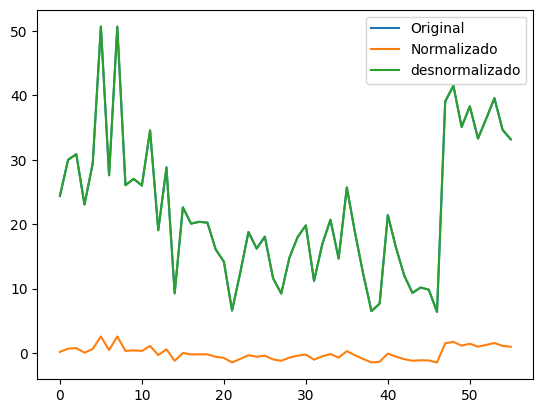

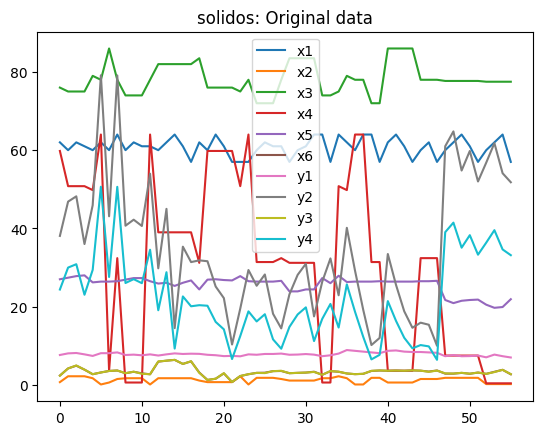

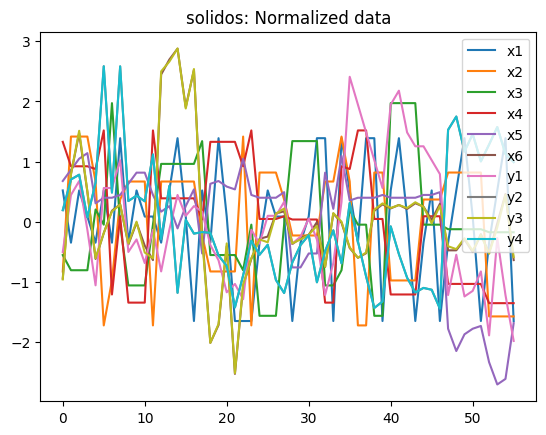

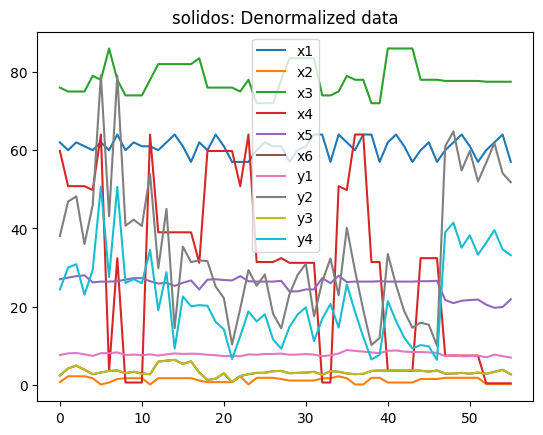

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5, x6  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6']

    input = np.vstack([x1, x2, x3, x4, x5, x6 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y4"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y4")
test_out_scaler()
show_norm(label="solidos")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-26 20:01:16.874517: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 20:01:16.918599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 20:01:16.918646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 20:01:16.920089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 20:01:16.929118: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 20:01:16.930190: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=6,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[30], [25], [20], [25, 15], [20, 10], [35], [10, 5], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.9883447189995422
Stopped at epoch:  10
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.1964456160003465
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.2713923530000102
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.306169872999817
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.28950514099960856
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.3230076800000461
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 7 ++++++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_3_0,0.814020,0.579279,0.602903,0.593898,22.429199,44.842620,43.257940,44.096891
model_1_3_1,0.825682,0.583855,0.577051,0.584072,21.022846,44.354870,46.074135,45.163933
model_1_3_2,0.834603,0.585279,0.554871,0.574341,19.946874,44.203077,48.490308,46.220602
model_1_3_3,0.841338,0.584403,0.535519,0.564749,19.134683,44.296487,50.598342,47.262067
model_1_3_4,0.846334,0.581883,0.518395,0.555356,18.532208,44.565024,52.463761,48.282073
model_1_3_5,0.849954,0.578224,0.503077,0.546222,18.095577,44.955051,54.132513,49.273850
model_1_3_17,0.852422,0.522132,0.398415,0.467663,17.797964,50.933620,65.533818,57.804297
model_1_3_6,0.852493,0.573804,0.489262,0.537403,17.789385,45.426184,55.637403,50.231463
model_1_3_16,0.853106,0.525819,0.403428,0.471945,17.715471,50.540621,64.987817,57.339303
model_1_3_15,0.853777,0.529776,0.408930,0.476599,17.634501,50.118957,64.388414,56.834012


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Elapsed time:  0.3368771929999639
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Elapsed time:  0.2941456870003094
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Elapsed time:  0.3437519709996195
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Elapsed time:  0.2724083969997082
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Elapsed time:  0.34508481600005325
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Elapsed time:  0.45550515099967015
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Elapsed time:  0.3711666760

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_4_0,0.876083,0.989216,0.887367,0.958911,14.944448,1.496866,10.036768,5.515643
model_1_4_24,0.879089,0.652744,0.469686,0.644242,14.581870,48.199514,47.256597,47.755784
model_1_4_23,0.880661,0.657804,0.477270,0.649381,14.392285,47.497202,46.580767,47.065915
model_1_4_22,0.882374,0.663393,0.485623,0.655050,14.185770,46.721394,45.836461,46.304953
model_1_4_21,0.884234,0.669563,0.494810,0.661297,13.961411,45.864991,45.017721,45.466288
model_1_4_20,0.886249,0.676369,0.504904,0.668176,13.718426,44.920334,44.118301,44.542904
model_1_4_19,0.888423,0.683870,0.515973,0.675741,13.456258,43.879145,43.131873,43.527486
model_1_4_18,0.890758,0.692131,0.528090,0.684048,13.174622,42.732542,42.052122,42.412338
model_1_4_1,0.893154,0.975968,0.874634,0.947681,12.885637,3.335716,11.171442,7.023116
model_1_4_17,0.893254,0.701219,0.541326,0.693157,12.873643,41.471091,40.872738,41.189508


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Elapsed time:  0.3350795989999824
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Elapsed time:  0.30836863900003664
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Elapsed time:  0.32831539700055146
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Elapsed time:  0.368874372999926
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Elapsed time:  0.3286401220002517
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Elapsed time:  0.34855542900004366
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Elapsed time:  0.3651657330

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_5_0,0.888971,0.720922,0.835274,0.802339,13.390183,22.215885,28.481024,25.164191
model_1_5_1,0.896680,0.727850,0.825197,0.798192,12.460368,21.664317,30.223407,25.692122
model_1_5_2,0.902664,0.734252,0.815329,0.794005,11.738770,21.154722,31.929577,26.225237
model_1_5_3,0.907277,0.740145,0.805811,0.789872,11.182466,20.685647,33.575265,26.751347
model_1_5_4,0.910804,0.745551,0.796738,0.785863,10.757045,20.255314,35.144042,27.261779
model_1_5_5,0.913474,0.750493,0.788169,0.782023,10.435030,19.861859,36.625496,27.750626
model_1_5_6,0.915469,0.755000,0.780139,0.778382,10.194451,19.503129,38.013937,28.214109
model_1_5_7,0.916934,0.759098,0.772659,0.774959,10.017738,19.176840,39.307260,28.649975
model_1_5_8,0.917986,0.762817,0.765727,0.771759,9.890918,18.880799,40.505828,29.057276
model_1_5_24,0.917986,0.790604,0.709508,0.745028,9.890904,16.668834,50.225956,32.460419


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.3235455079993699
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.3183999969996876
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.33984915200016985
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.3080899649994535
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.34580898999956844
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.34933326600003056
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.369216639

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_6_0,0.929558,0.701175,0.989991,0.950634,8.495317,9.953541,1.295390,5.879118
model_1_6_1,0.938130,0.674251,0.984636,0.943909,7.461546,10.850354,1.988386,6.680014
model_1_6_2,0.944371,0.645332,0.977779,0.936120,6.708881,11.813610,2.875846,7.607601
model_1_6_24,0.946502,0.281592,0.861333,0.822711,6.451858,23.929357,17.946264,21.113785
model_1_6_23,0.946959,0.287035,0.863274,0.824509,6.396773,23.748087,17.695050,20.899602
model_1_6_22,0.947453,0.293060,0.865418,0.826498,6.337136,23.547393,17.417490,20.662734
model_1_6_21,0.947987,0.299732,0.867787,0.828698,6.272781,23.325161,17.110968,20.400839
model_1_6_20,0.948560,0.307110,0.870400,0.831126,6.203685,23.079402,16.772800,20.111597
model_1_6_3,0.948811,0.615735,0.970012,0.927766,6.173348,12.799450,3.881021,8.602540
model_1_6_19,0.949172,0.315270,0.873279,0.833807,6.129867,22.807611,16.400130,19.792321


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.3425851619995228
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.33807106299991574
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.31524093099960737
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.3854778600007194
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.3198583530001997
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.3524688920006156
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.3618567780

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_7_0,0.955802,0.997440,0.943614,0.986867,5.330292,0.515712,3.556434,1.946642
model_1_7_1,0.962942,0.996042,0.943916,0.985922,4.469165,0.797379,3.537369,2.086789
model_1_7_2,0.968375,0.994036,0.942722,0.984239,3.813999,1.201463,3.612702,2.336161
model_1_7_3,0.972461,0.991626,0.940455,0.982051,3.321164,1.686958,3.755647,2.660461
model_1_7_4,0.975491,0.988970,0.937444,0.979538,2.955788,2.221934,3.945570,3.033050
model_1_7_5,0.977694,0.986189,0.933942,0.976836,2.690116,2.782069,4.166439,3.433532
model_1_7_24,0.978055,0.952417,0.880574,0.941850,2.646603,9.585400,7.532516,8.619337
model_1_7_23,0.978300,0.953179,0.881900,0.942664,2.617024,9.431848,7.448920,8.498706
model_1_7_22,0.978562,0.954019,0.883356,0.943560,2.585406,9.262656,7.357067,8.365911
model_1_7_21,0.978841,0.954943,0.884953,0.944545,2.551822,9.076445,7.256335,8.219925


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  0.38330251300067175
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.30069159300001047
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.3967731110005843
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.28684202800013736
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.35270641099941713
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.32910421599990514
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.3378897

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_8_24,0.979621,0.929585,0.917701,0.921860,2.457756,4.745797,11.810734,8.070473
model_1_8_23,0.979873,0.930457,0.918814,0.922889,2.427313,4.687046,11.650947,7.964173
model_1_8_22,0.980149,0.931417,0.920040,0.924022,2.394035,4.622287,11.475057,7.847121
model_1_8_21,0.980450,0.932477,0.921388,0.925270,2.357709,4.550898,11.281593,7.718287
model_1_8_20,0.980778,0.933641,0.922867,0.926640,2.318193,4.472393,11.069246,7.576796
model_1_8_19,0.981134,0.934921,0.924490,0.928143,2.275298,4.386122,10.836343,7.421518
model_1_8_18,0.981518,0.936327,0.926266,0.929790,2.228903,4.291406,10.581469,7.251438
model_1_8_17,0.981933,0.937867,0.928206,0.931590,2.178922,4.187635,10.303091,7.065499
model_1_8_16,0.982377,0.939551,0.930320,0.933554,2.125333,4.074137,9.999795,6.862685
model_1_8_15,0.982851,0.941388,0.932616,0.935690,2.068202,3.950299,9.670267,6.642047


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.32312127400018653
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.31212830700042105
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.3330283280001822
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.30711319600050047
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step


2024-05-26 20:03:48.965387: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.3380889070003832
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.2587152819996845
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.28063194300011673
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Elapsed time:  0.3157311639997715
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++++
Elapsed time:  0.3153025539995724
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_9] | 10 ++++++++++++++++++
Elapsed time:  0.28615269900001294
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [1_9] | 11 ++++++++++++++++++
Elapsed time:  

2024-05-26 20:03:55.516046: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 15 ++++++++++++++++++
Elapsed time:  0.3370584049998797
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 16 ++++++++++++++++++
Elapsed time:  0.3006379879998349
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_9] | 17 ++++++++++++++++++
Elapsed time:  0.32749823299946
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_9] | 18 ++++++++++++++++++
Elapsed time:  0.33725634399979754
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [1_9] | 19 ++++++++++++++++++
Elapsed time:  0.3497051399999691
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 20 ++++++++++++++++++
Elapsed time:  0.3524116319995301
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_9] | 21 ++++++++++++++++++
Elapsed time:

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_9_0,0.983161,0.996889,0.997143,0.997406,2.030843,0.256921,0.426273,0.336617
model_1_9_1,0.985932,0.996405,0.995941,0.996593,1.696635,0.296919,0.605572,0.442170
model_1_9_2,0.988089,0.995763,0.994625,0.995664,1.436510,0.349957,0.801962,0.562666
model_1_9_3,0.989756,0.995012,0.993248,0.994666,1.235461,0.411969,1.007385,0.692164
model_1_9_4,0.991033,0.994191,0.991851,0.993634,1.081400,0.479744,1.215750,0.826101
model_1_9_5,0.992002,0.993331,0.990466,0.992595,0.964602,0.550748,1.422469,0.960971
model_1_9_6,0.992726,0.992456,0.989114,0.991569,0.877246,0.623005,1.624209,1.094155
model_1_9_7,0.993258,0.991584,0.987811,0.990570,0.813064,0.695011,1.818590,1.223755
model_1_9_24,0.993595,0.982254,0.975387,0.980705,0.772429,1.465561,3.672190,2.503977
model_1_9_8,0.993640,0.990730,0.986568,0.989610,0.767028,0.765608,2.003969,1.348364


DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.7057949250001911
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.3488974990004863
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.3057818959996439
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.2874207819995718
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.307612051000433
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.37336939699980576
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_3_0,0.802640,0.203893,0.797695,0.515632,23.801628,71.601002,19.721261,47.187023
model_2_3_1,0.823951,0.256071,0.798265,0.541402,21.231506,66.908171,19.665755,44.676456
model_2_3_2,0.840998,0.298536,0.796794,0.561465,19.175630,63.088851,19.809134,42.721932
model_2_3_3,0.854590,0.333050,0.793712,0.576883,17.536517,59.984762,20.109579,41.219970
model_2_3_4,0.865390,0.361082,0.789404,0.588555,16.234065,57.463548,20.529555,40.082839
model_2_3_5,0.873941,0.383856,0.784204,0.597238,15.202731,55.415320,21.036408,39.237007
model_2_3_6,0.880688,0.402370,0.778401,0.603554,14.389114,53.750159,21.602128,38.621665
model_2_3_7,0.885988,0.417440,0.772232,0.608015,13.749884,52.394772,22.203450,38.187088
model_2_3_8,0.890134,0.429729,0.765894,0.611036,13.249908,51.289538,22.821321,37.892741
model_2_3_9,0.893359,0.439768,0.759539,0.612951,12.860901,50.386603,23.440874,37.706255


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Elapsed time:  0.3834592129996963
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Elapsed time:  0.3283520059994771
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Elapsed time:  0.3119801489992824
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Elapsed time:  0.378938862000723
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Elapsed time:  0.39719891300046584
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Elapsed time:  0.32379790100003447
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Elapsed time:  0.35569225699

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_4_0,0.912109,0.534952,0.959985,0.862162,10.599678,29.403952,9.286971,19.937140
model_2_4_24,0.914082,0.196532,0.934603,0.764678,10.361782,50.801482,15.177726,34.037363
model_2_4_23,0.914743,0.203121,0.935195,0.766650,10.282012,50.384900,15.040328,33.752178
model_2_4_22,0.915464,0.210384,0.935844,0.768821,10.195087,49.925695,14.889733,33.438174
model_2_4_21,0.916247,0.218379,0.936554,0.771207,10.100663,49.420139,14.724931,33.092988
model_2_4_20,0.917094,0.227169,0.937329,0.773827,9.998430,48.864369,14.545002,32.714071
model_2_4_19,0.918009,0.236817,0.938174,0.776697,9.888190,48.254362,14.348989,32.298900
model_2_4_18,0.918990,0.247385,0.939091,0.779836,9.769884,47.586162,14.136117,31.844967
model_2_4_1,0.919026,0.532968,0.959672,0.861466,9.765464,29.529406,9.359642,20.037754
model_2_4_17,0.920037,0.258939,0.940085,0.783260,9.643599,46.855648,13.905495,31.349699


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Elapsed time:  0.33575144600035856
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Elapsed time:  0.2700478729993847
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Elapsed time:  0.3914807559995097
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Elapsed time:  0.3896511470002224
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Elapsed time:  0.29205030999946757
Stopped at epoch:  6
1/1 [==============================] - 0s 49ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Elapsed time:  0.2966234440000335
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Elapsed time:  0.3289065250

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_24,0.860716,0.758161,0.559141,0.632204,16.797701,19.632487,95.301984,55.241660
model_2_5_23,0.861794,0.762483,0.561737,0.635200,16.667676,19.281576,94.740750,54.791774
model_2_5_22,0.862979,0.767232,0.564621,0.638511,16.524765,18.896090,94.117457,54.294381
model_2_5_21,0.864279,0.772440,0.567821,0.642169,16.367948,18.473286,93.425532,53.744935
model_2_5_20,0.865704,0.778144,0.571375,0.646209,16.196094,18.010223,92.657266,53.138241
model_2_5_19,0.867263,0.784381,0.575321,0.650666,16.008088,17.503919,91.804335,52.468823
model_2_5_18,0.868965,0.791187,0.579700,0.655579,15.802827,16.951398,90.857653,51.730811
model_2_5_17,0.870820,0.798598,0.584561,0.660992,15.579205,16.349803,89.806824,50.917812
model_2_5_16,0.872835,0.806647,0.589956,0.666949,15.336197,15.696356,88.640556,50.023039
model_2_5_15,0.875018,0.815366,0.595942,0.673498,15.072926,14.988596,87.346579,49.039412


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.5347842889996173
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.3185662819996651
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.3824186890005876
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.3175034699997923
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.32097758799955045
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.36841887600076006
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.3305838840

2024-05-26 20:05:46.648216: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Elapsed time:  0.3125453620004919
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_6] | 9 ++++++++++++++++++
Elapsed time:  0.32567810399996233
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_6] | 10 ++++++++++++++++++
Elapsed time:  0.38971939500061126
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_6] | 11 ++++++++++++++++++
Elapsed time:  0.3748015259998283
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 12 ++++++++++++++++++
Elapsed time:  0.3744211660005021
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_6] | 13 ++++++++++++++++++
Elapsed time:  0.3324926979994416
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_6] | 14 ++++++++++++++++++
Elapsed time

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.934545,0.950742,0.996580,0.981997,7.893898,3.682521,0.582694,2.223780
model_2_6_1,0.943805,0.932051,0.995316,0.975188,6.777177,5.079804,0.798188,3.064928
model_2_6_2,0.950821,0.912715,0.993970,0.968119,5.931029,6.525356,1.027485,3.938123
model_2_6_3,0.956067,0.893276,0.992587,0.960993,5.298277,7.978602,1.263108,4.818371
model_2_6_4,0.959923,0.874124,0.991200,0.953956,4.833263,9.410403,1.499452,5.687606
model_2_6_24,0.961188,0.665105,0.974897,0.876401,4.680725,25.036465,4.277526,15.267549
model_2_6_23,0.961568,0.669141,0.975229,0.877909,4.634934,24.734802,4.220949,15.081219
model_2_6_22,0.961975,0.673592,0.975595,0.879572,4.585857,24.402045,4.158646,14.875742
model_2_6_21,0.962409,0.678498,0.975997,0.881406,4.533535,24.035242,4.090110,14.649299
model_2_6_5,0.962691,0.855536,0.989833,0.947113,4.499535,10.800022,1.732364,6.532894


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.3490284260005865
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.3695217960002992
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.3733972759991957
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.31727420199968037
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.3851927659998182
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.29511622300015006
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.3704285029

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_0,0.965587,0.941812,0.979435,0.952374,4.150182,11.387321,1.751608,6.852869
model_2_7_1,0.969065,0.942573,0.979614,0.952972,3.730735,11.238289,1.736360,6.766793
model_2_7_2,0.971805,0.943031,0.979405,0.953243,3.400319,11.148729,1.754130,6.727741
model_2_7_3,0.973954,0.943258,0.978914,0.953270,3.141117,11.104265,1.795941,6.723877
model_2_7_4,0.975632,0.943313,0.978225,0.953117,2.938791,11.093590,1.854640,6.745852
model_2_7_5,0.976934,0.943240,0.977402,0.952836,2.781808,11.107809,1.924730,6.786360
model_2_7_6,0.977937,0.943076,0.976497,0.952465,2.660861,11.139878,2.001860,6.839633
model_2_7_7,0.978702,0.942849,0.975547,0.952037,2.568510,11.184387,2.082765,6.901272
model_2_7_8,0.979281,0.942579,0.974582,0.951574,2.498761,11.237110,2.164918,6.967846
model_2_7_9,0.979711,0.942284,0.973625,0.951095,2.446819,11.294837,2.246477,7.036787


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.3583815579995644
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.4254844819997743
Stopped at epoch:  6
1/1 [==============================] - 0s 62ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.2737990460000219
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.3390524540000115
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.36129662999974244
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.334712529999706
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.326675418000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_24,0.971907,0.924164,0.922792,0.923461,3.387992,8.445785,14.144494,11.127531
model_2_8_23,0.972276,0.925008,0.924004,0.924522,3.343514,8.351813,13.922469,10.973299
model_2_8_22,0.972680,0.925939,0.925341,0.925692,3.294760,8.248189,13.677525,10.803171
model_2_8_21,0.973123,0.926964,0.926815,0.926982,3.241399,8.133997,13.407488,10.615636
model_2_8_20,0.973606,0.928093,0.928439,0.928403,3.183111,8.008274,13.110061,10.409115
model_2_8_19,0.974133,0.929334,0.930224,0.929965,3.119601,7.870052,12.782937,10.181995
model_2_8_18,0.974705,0.930697,0.932186,0.931681,3.050589,7.718288,12.423600,9.932552
model_2_8_17,0.975325,0.932191,0.934337,0.933562,2.975833,7.551910,12.029493,9.659008
model_2_8_16,0.975994,0.933825,0.936692,0.935622,2.895168,7.369838,11.598102,9.359607
model_2_8_15,0.976712,0.935611,0.939264,0.937871,2.808525,7.171024,11.126934,9.032628


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.307209585000237
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.2958477030006179
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.3117237699998441
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.2697762469997542
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.36513002600077016
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.3355737649999355
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.396396837999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_0,0.976986,0.989525,0.989879,0.990080,2.775546,0.699227,1.318507,0.990652
model_2_9_1,0.980869,0.987542,0.990778,0.989931,2.307231,0.831582,1.201413,1.005619
model_2_9_2,0.983797,0.985112,0.990622,0.988975,1.954123,0.993819,1.221690,1.101052
model_2_9_3,0.985965,0.982348,0.989673,0.987414,1.692569,1.178337,1.345370,1.256941
model_2_9_24,0.986862,0.931018,0.955473,0.948255,1.584409,4.604818,5.800918,5.167686
model_2_9_23,0.987050,0.932224,0.956189,0.949122,1.561797,4.524272,5.707558,5.081112
model_2_9_22,0.987252,0.933542,0.956981,0.950074,1.537457,4.436296,5.604425,4.986005
model_2_9_21,0.987468,0.934979,0.957855,0.951119,1.511368,4.340373,5.490559,4.881634
model_2_9_4,0.987535,0.979347,0.988150,0.985417,1.503314,1.378652,1.543840,1.456387
model_2_9_20,0.987698,0.936542,0.958819,0.952264,1.483571,4.236030,5.365026,4.767319


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  1.004482208999434
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.373789276000025
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.34399939000013546
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.2924186919999556
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.3615495660005763
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.35396324600060325
Stopped at epoch:  6
1/1 [==============================] - 0s 18m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912
model_3_3_22,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912
model_3_3_21,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912
model_3_3_20,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912
model_3_3_19,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912
model_3_3_18,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912
model_3_3_17,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912
model_3_3_16,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912
model_3_3_15,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912
model_3_3_14,0.858593,0.574013,0.517602,0.582281,17.053705,62.349829,49.232364,56.176912


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.06835842100008449
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.05011257200021646
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.05783489199984615
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.044002014999932726
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.059560941999734496
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.06432878399937181
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.0477

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_0,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757
model_3_4_22,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757
model_3_4_21,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757
model_3_4_20,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757
model_3_4_19,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757
model_3_4_18,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757
model_3_4_17,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757
model_3_4_16,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757
model_3_4_15,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757
model_3_4_14,0.858593,1.0,0.290707,0.785634,17.053705,1.259506e-10,62.644483,29.479757


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.05701003400008631
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.03892055999949662
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.057375585999579926
Stopped at epoch:  0
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.05847369599996455
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.05455425699983607
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.05949361300008604
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.04744

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976
model_3_5_22,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976
model_3_5_21,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976
model_3_5_20,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976
model_3_5_19,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976
model_3_5_18,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976
model_3_5_17,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976
model_3_5_16,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976
model_3_5_15,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976
model_3_5_14,0.858593,0.999012,0.81657,0.881526,17.053705,0.050616,21.881505,10.323976


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.039220706000378414
Stopped at epoch:  0
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.05144788699999481
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.053280822000488115
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.03780443000050582
Stopped at epoch:  0
1/1 [==============================] - 0s 29ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.05307941699993535
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.04985451999982615
Stopped at epoch:  0
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.0324

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647
model_3_6_22,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647
model_3_6_21,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647
model_3_6_20,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647
model_3_6_19,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647
model_3_6_18,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647
model_3_6_17,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647
model_3_6_16,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647
model_3_6_15,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647
model_3_6_14,0.858593,0.99574,0.976511,0.983226,17.053705,0.286004,3.729495,1.90647


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.06144001499978913
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.06570168899997952
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.05078246799985209
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.0320607329995255
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.04635040900029708
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.0399913960000049
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.06059294

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542
model_3_7_22,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542
model_3_7_21,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542
model_3_7_20,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542
model_3_7_19,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542
model_3_7_18,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542
model_3_7_17,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542
model_3_7_16,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542
model_3_7_15,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542
model_3_7_14,0.858593,1.0,0.913992,0.942821,17.053705,1.156967e-10,8.941028,4.207542


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.06086458699974173
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.03321083599985286
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.032245289999991655
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.043257616000119015
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.03969221399984235
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.03683823800020036
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.0528

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976
model_3_8_22,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976
model_3_8_21,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976
model_3_8_20,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976
model_3_8_19,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976
model_3_8_18,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976
model_3_8_17,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976
model_3_8_16,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976
model_3_8_15,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976
model_3_8_14,0.858593,0.820804,0.598517,0.683121,17.053705,15.492874,63.870842,38.258976


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.04990545700002258
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.05623431599997275
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.044997595000495494
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.04996864500026277
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.049089733000073466
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.04937124000025506
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.0496

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_0,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537
model_3_9_22,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537
model_3_9_21,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537
model_3_9_20,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537
model_3_9_19,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537
model_3_9_18,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537
model_3_9_17,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537
model_3_9_16,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537
model_3_9_15,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537
model_3_9_14,0.858593,1.0,-0.138783,0.676201,17.053705,1.861768e-10,84.251017,39.647537


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.7408328600004097
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.28739901799963263
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.35964643099941895
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.3485354049998932
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.28666903099929186
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.4110909430000902
Stopped at epoch:  6
1/1 [==============================] - 0s 2

2024-05-26 20:09:20.441490: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_1] | 15 ++++++++++++++++++
Elapsed time:  0.28049209599976166
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_1] | 16 ++++++++++++++++++
Elapsed time:  0.41979887900015456
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_1] | 17 ++++++++++++++++++
Elapsed time:  0.30478853699969477
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_1] | 18 ++++++++++++++++++
Elapsed time:  0.321331631999783
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_1] | 19 ++++++++++++++++++
Elapsed time:  0.2324607399996239
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_1] | 20 ++++++++++++++++++
Elapsed time:  0.3373411920001672
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_1] | 21 ++++++++++++++++++
Elapsed ti

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_0,0.812325,-0.419610,0.964134,0.632386,22.633643,85.706282,7.147690,48.737563
model_4_3_1,0.828264,-0.347299,0.954659,0.643117,20.711399,81.340610,9.035916,47.314861
model_4_3_2,0.840795,-0.287247,0.944894,0.650686,19.200185,77.715065,10.982069,46.311329
model_4_3_3,0.850599,-0.237425,0.935129,0.655790,18.017786,74.707206,12.928105,45.634666
model_4_3_4,0.858228,-0.196108,0.925572,0.658991,17.097785,72.212765,14.832623,45.210314
model_4_3_5,0.864124,-0.161851,0.916367,0.660738,16.386693,70.144574,16.667160,44.978729
model_4_3_6,0.868645,-0.133439,0.907607,0.661391,15.841400,68.429239,18.412915,44.892148
model_4_3_7,0.872079,-0.109866,0.899350,0.661233,15.427344,67.006032,20.058515,44.913064
model_4_3_8,0.874653,-0.090293,0.891625,0.660487,15.116834,65.824370,21.598031,45.011974
model_4_3_9,0.876554,-0.074027,0.884442,0.659327,14.887640,64.842333,23.029508,45.165699


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.3888657580000654
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.3649340989995835
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.33584292700015794
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.2778274499996769
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.33842561500023294
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.33207652100009
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.318316494000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.908633,0.963795,0.766192,0.902755,11.018910,6.314391,20.512604,12.995904
model_4_4_1,0.918709,0.961468,0.761701,0.899760,9.803775,6.720129,20.906605,13.396129
model_4_4_2,0.926529,0.958957,0.756051,0.896280,8.860592,7.158049,21.402286,13.861208
model_4_4_3,0.932547,0.956366,0.749562,0.892485,8.134857,7.609958,21.971554,14.368359
model_4_4_4,0.937127,0.953766,0.742514,0.888511,7.582494,8.063445,22.589941,14.899446
model_4_4_5,0.940565,0.951204,0.735142,0.884464,7.167876,8.510242,23.236686,15.440329
model_4_4_6,0.943100,0.948715,0.727641,0.880427,6.862207,8.944380,23.894764,15.979864
model_4_4_24,0.944399,0.923132,0.640535,0.835842,6.705481,13.406190,31.536812,21.938236
model_4_4_23,0.944690,0.923760,0.642779,0.836969,6.670460,13.296656,31.339963,21.787621
model_4_4_7,0.944923,0.946320,0.720165,0.876463,6.642291,9.361950,24.550709,16.509603


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.36906399899999087
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.4169927849998203
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.3378040309999051
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.35568608900030085
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.3233558459996857
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.3121860719993492
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.3163597950

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_0,0.952524,0.992130,0.885647,0.965015,5.725668,1.473444,8.342161,4.705787
model_4_5_1,0.958783,0.990639,0.883069,0.963259,4.970779,1.752575,8.530208,4.942054
model_4_5_2,0.963567,0.988935,0.879345,0.961053,4.393809,2.071543,8.801893,5.238769
model_4_5_3,0.967188,0.987110,0.874864,0.958565,3.957112,2.413249,9.128770,5.573498
model_4_5_4,0.969896,0.985231,0.869927,0.955920,3.630604,2.765023,9.488965,5.929241
model_4_5_5,0.971888,0.983347,0.864757,0.953212,3.390348,3.117652,9.866146,6.293416
model_4_5_24,0.973164,0.961871,0.802088,0.921394,3.236400,7.138261,14.437906,10.573378
model_4_5_6,0.973322,0.981495,0.859522,0.950511,3.217318,3.464487,10.248020,6.656738
model_4_5_23,0.973357,0.962364,0.803499,0.922117,3.213126,7.046062,14.334923,10.476115
model_4_5_22,0.973563,0.962905,0.805054,0.922912,3.188359,6.944755,14.221483,10.369093


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  1.2482596119998561
Stopped at epoch:  28
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.27757868400021835
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.2779060650000247
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.2897934440006793
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.2943820529999357
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.25781845500023337
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.235698833

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_24,0.974958,0.486732,0.928304,0.890326,3.020075,13.319023,6.156084,9.948225
model_4_6_23,0.974981,0.487132,0.928396,0.890428,3.017293,13.308640,6.148183,9.938998
model_4_6_22,0.975007,0.487578,0.928499,0.890541,3.014202,13.297067,6.139380,9.928743
model_4_6_21,0.975035,0.488070,0.928612,0.890666,3.010778,13.284295,6.129601,9.917371
model_4_6_20,0.975067,0.488617,0.928739,0.890805,3.006987,13.270110,6.118762,9.904769
model_4_6_19,0.975101,0.489225,0.928879,0.890959,3.002774,13.254330,6.106720,9.890749
model_4_6_18,0.975140,0.489899,0.929034,0.891131,2.998109,13.236841,6.093370,9.875207
model_4_6_17,0.975183,0.490646,0.929207,0.891321,2.992942,13.217462,6.078551,9.857973
model_4_6_16,0.975230,0.491473,0.929399,0.891532,2.987217,13.195980,6.062083,9.838849
model_4_6_15,0.975283,0.492390,0.929611,0.891765,2.980889,13.172203,6.043839,9.817677


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.2501978840000447
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.34797490800065134
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.25739237499965384
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.1968449009991673
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.33942729299997154
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.2535078139999314
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.233050805

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.978558,0.978639,0.985759,0.981699,2.585877,3.328624,0.883473,2.177964
model_4_7_1,0.981288,0.977452,0.985115,0.980718,2.256660,3.513585,0.923461,2.294703
model_4_7_2,0.983326,0.975857,0.984000,0.979339,2.010866,3.762164,0.992630,2.458855
model_4_7_24,0.984439,0.940942,0.956523,0.948395,1.876682,9.202860,2.697262,6.141401
model_4_7_23,0.984598,0.941637,0.957054,0.949007,1.857461,9.094528,2.664357,6.068562
model_4_7_22,0.984770,0.942401,0.957637,0.949679,1.836727,8.975482,2.628162,5.988508
model_4_7_3,0.984817,0.973973,0.982567,0.977681,1.831092,4.055703,1.081535,2.656095
model_4_7_21,0.984955,0.943239,0.958278,0.950418,1.814464,8.844912,2.588380,5.900661
model_4_7_20,0.985152,0.944157,0.958982,0.951226,1.790682,8.701915,2.544715,5.804407
model_4_7_19,0.985361,0.945160,0.959753,0.952111,1.765431,8.545556,2.496870,5.699114


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.4009030370007167
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.26791735900042113
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.32454949299972213
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.254469391999919
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.20413500199992995
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.24499833100071555
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.255715671

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_24,0.984162,0.989711,0.801437,0.953943,1.910050,1.925226,11.190058,6.285147
model_4_8_23,0.984210,0.989844,0.801717,0.954094,1.904277,1.900319,11.174278,6.264536
model_4_8_22,0.984262,0.989991,0.802026,0.954261,1.897980,1.872904,11.156861,6.241827
model_4_8_21,0.984319,0.990152,0.802368,0.954444,1.891118,1.842754,11.137590,6.216795
model_4_8_20,0.984381,0.990329,0.802747,0.954646,1.883656,1.809657,11.116235,6.189222
model_4_8_19,0.984448,0.990523,0.803165,0.954868,1.875577,1.773341,11.092678,6.158911
model_4_8_18,0.984520,0.990735,0.803627,0.955112,1.866855,1.733617,11.066611,6.125613
model_4_8_17,0.984598,0.990967,0.804137,0.955380,1.857486,1.690207,11.037884,6.089113
model_4_8_16,0.984681,0.991220,0.804699,0.955673,1.847464,1.642875,11.006188,6.049142
model_4_8_15,0.984769,0.991495,0.805319,0.955993,1.836812,1.591414,10.971258,6.005460


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.3764072359999773
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.27374520000012126
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.25186837799992645
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.2976379159999851
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.32045060100062983
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.260698916000365
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.2223783330

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_0,0.984721,0.938802,0.999177,0.953273,1.842612,9.699165,0.038615,5.153022
model_4_9_1,0.985143,0.938955,0.998297,0.953213,1.791728,9.674944,0.079899,5.159618
model_4_9_2,0.985457,0.939074,0.997108,0.953065,1.753837,9.656103,0.135694,5.175910
model_4_9_3,0.985687,0.939165,0.995721,0.952858,1.726102,9.641554,0.200779,5.198836
model_4_9_24,0.985756,0.939398,0.974272,0.948739,1.717865,9.604742,1.207332,5.653020
model_4_9_23,0.985776,0.939400,0.974683,0.948823,1.715454,9.604310,1.188032,5.643710
model_4_9_22,0.985797,0.939403,0.975136,0.948916,1.712855,9.603844,1.166766,5.633461
model_4_9_21,0.985820,0.939406,0.975635,0.949019,1.710069,9.603393,1.143350,5.622198
model_4_9_20,0.985845,0.939409,0.976184,0.949131,1.707095,9.602928,1.117605,5.609829
model_4_9_4,0.985852,0.939236,0.994220,0.952611,1.706269,9.630381,0.271225,5.226076


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.9021736879994933
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.22374194399981207
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.33244557099988015
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.28695787500055303
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.29678935799984174
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.32868157000029896
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.817510,0.741304,0.963366,0.877501,22.008307,18.397729,3.892729,11.571845
model_5_5_1,0.836772,0.652134,0.947776,0.833710,19.685354,24.739181,5.549201,15.708600
model_5_5_2,0.850547,0.566649,0.932114,0.791348,18.024114,30.818675,7.213493,19.710355
model_5_5_22,0.854487,-0.177464,0.742090,0.394185,17.548962,83.737769,27.405201,57.228328
model_5_5_21,0.855842,-0.165125,0.746286,0.401324,17.385520,82.860284,26.959252,56.553918
model_5_5_20,0.857292,-0.151470,0.750885,0.409201,17.210615,81.889203,26.470593,55.809854
model_5_5_19,0.858835,-0.136362,0.755916,0.417885,17.024491,80.814754,25.936007,54.989460
model_5_5_3,0.860252,0.486994,0.916734,0.751459,16.853639,36.483490,8.847739,23.478432
model_5_5_18,0.860467,-0.119651,0.761412,0.427455,16.827755,79.626303,25.352049,54.085484
model_5_5_17,0.862177,-0.101174,0.767404,0.437991,16.621516,78.312282,24.715333,53.090183


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.32158993799930613
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.26726670600055513
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.24396208799953456
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.27672037899992574
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.22276554000018223
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.31526407199999085
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.373717

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_0,0.876854,0.859228,0.953669,0.905555,14.851503,9.664233,3.436103,6.733348
model_5_6_1,0.892726,0.812452,0.950371,0.880094,12.937248,12.875553,3.680741,8.548583
model_5_6_24,0.901950,0.144321,0.782651,0.457381,11.824862,58.743948,16.119589,38.685439
model_5_6_23,0.902719,0.152333,0.784855,0.462544,11.732118,58.193909,15.956137,38.317308
model_5_6_22,0.903558,0.161282,0.787298,0.468302,11.630975,57.579594,15.774999,37.906841
model_5_6_2,0.903770,0.761893,0.941520,0.849986,11.605411,16.346527,4.337171,10.695065
model_5_6_21,0.904470,0.171281,0.790004,0.474724,11.520932,56.893118,15.574262,37.448941
model_5_6_20,0.905460,0.182457,0.793005,0.481890,11.401591,56.125896,15.351731,36.938057
model_5_6_19,0.906529,0.194950,0.796330,0.489887,11.272644,55.268222,15.105140,36.367946
model_5_6_18,0.907679,0.208916,0.800015,0.498811,11.133965,54.309394,14.831818,35.731708


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.3159793280001395
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.26630719199965824
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.2317593970001326
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.34779477000029146
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.3193155279996063
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.3111706480003704
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.2796753230

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.917862,0.987993,0.952568,0.966347,9.905908,0.834949,5.877748,3.208030
model_5_7_24,0.927508,0.792081,0.640637,0.699866,8.742504,14.458676,44.532388,28.611002
model_5_7_23,0.928492,0.795769,0.645767,0.704428,8.623830,14.202172,43.896694,28.176065
model_5_7_1,0.929342,0.980929,0.938402,0.954953,8.521402,1.326171,7.633202,4.294185
model_5_7_22,0.929558,0.799808,0.651409,0.709440,8.495297,13.921345,43.197518,27.698357
model_5_7_21,0.930709,0.804223,0.657608,0.714936,8.356571,13.614322,42.429399,27.174356
model_5_7_20,0.931945,0.809042,0.664409,0.720958,8.207424,13.279200,41.586618,26.600338
model_5_7_19,0.933268,0.814289,0.671859,0.727542,8.047869,12.914295,40.663380,25.972688
model_5_7_18,0.934676,0.819991,0.680009,0.734730,7.878100,12.517800,39.653442,25.287514
model_5_7_17,0.936164,0.826171,0.688906,0.742559,7.698690,12.088015,38.550884,24.541136


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.22928215800038743
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.26584026499949687
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.2578191579996201
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.27158496100037155
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.32185093899988715
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.29134308799984865
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.3403368

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.913861,0.737597,0.722430,0.746139,10.388362,37.930232,29.926271,34.163660
model_5_8_23,0.914395,0.739937,0.723341,0.747813,10.324016,37.591988,29.828061,33.938380
model_5_8_22,0.914978,0.742512,0.724350,0.749658,10.253638,37.219711,29.719305,33.690106
model_5_8_21,0.915615,0.745344,0.725466,0.751689,10.176806,36.810334,29.598924,33.416728
model_5_8_20,0.916309,0.748455,0.726702,0.753923,10.093123,36.360730,29.465738,33.116029
model_5_8_19,0.917063,0.751865,0.728069,0.756378,10.002218,35.867739,29.318351,32.785678
model_5_8_18,0.917879,0.755599,0.729580,0.759071,9.903778,35.328027,29.155417,32.423277
model_5_8_17,0.918760,0.759678,0.731249,0.762020,9.797573,34.738334,28.975405,32.026371
model_5_8_16,0.919706,0.764128,0.733093,0.765245,9.683444,34.095223,28.776631,31.592359
model_5_8_15,0.920718,0.768967,0.735128,0.768765,9.561421,33.395657,28.557261,31.118769


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.29096504300014203
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.27645095199932257
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.2317586500003017
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.20260465200044564
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.21584468399942125
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.21347180100019614
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.2771929

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_24,0.894276,0.610765,0.805596,0.705997,12.750305,54.558863,27.519662,41.834545
model_5_9_23,0.895702,0.616458,0.808342,0.710251,12.578373,53.760833,27.131013,41.229150
model_5_9_22,0.897267,0.622761,0.811377,0.714959,12.389647,52.877400,26.701388,40.559274
model_5_9_21,0.898981,0.629733,0.814728,0.720164,12.182868,51.900181,26.226910,39.818641
model_5_9_20,0.900857,0.637439,0.818428,0.725915,11.956731,50.819921,25.703190,39.000288
model_5_9_19,0.902903,0.645951,0.822509,0.732265,11.709985,49.626857,25.125554,38.096827
model_5_9_18,0.905129,0.655342,0.827004,0.739267,11.441498,48.310556,24.489171,37.100495
model_5_9_17,0.907544,0.665689,0.831952,0.746979,11.150279,46.860186,23.788766,36.003046
model_5_9_16,0.910153,0.677072,0.837391,0.755462,10.835628,45.264593,23.018844,34.796012
model_5_9_15,0.912958,0.689572,0.843360,0.764775,10.497245,43.512528,22.173890,33.470816


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.5883312589994603
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.2912284410003849
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.32940994299951853
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.2709084590005659
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.31388921500001743
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.286786485000448
Stopped at epoch:  6
1/1 [==============================] - 0s 16m

2024-05-26 20:14:14.787767: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.34221265999985917
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_1] | 21 ++++++++++++++++++
Elapsed time:  0.28231102200061287
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_1] | 22 ++++++++++++++++++
Elapsed time:  0.239740224000343
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_1] | 23 ++++++++++++++++++
Elapsed time:  0.3168620429996736
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_1] | 24 ++++++++++++++++++
Elapsed time:  0.26287737999973615
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_1] | 25 ++++++++++++++++++
Elapsed time:  0.25990831599938247
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_2] | 1 ++++++++++++++++++
Elapsed time:  0.2730409139994663
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/st

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_11,0.801879,-1.463029,0.629502,-0.054156,23.893399,112.569946,36.143589,76.604588
model_6_7_10,0.804369,-1.411413,0.634594,-0.033753,23.593174,110.210886,35.646828,75.121918
model_6_7_0,0.804761,-0.783783,0.716343,0.226869,23.545861,81.525794,27.671844,56.182778
model_6_7_9,0.806831,-1.356332,0.640152,-0.011902,23.296205,107.693506,35.104644,73.534053
model_6_7_8,0.809195,-1.297906,0.646207,0.011377,23.011198,105.023210,34.513933,71.842382
model_6_7_1,0.810195,-0.841114,0.705192,0.200735,22.890573,84.146049,28.759668,58.081872
model_6_7_7,0.811363,-1.236378,0.652790,0.036023,22.749720,102.211116,33.871761,70.051417
model_6_7_6,0.813211,-1.172141,0.659932,0.061923,22.526835,99.275270,33.174978,68.169243
model_6_7_2,0.813435,-0.904105,0.694759,0.173171,22.499855,87.024958,29.777464,60.084982
model_6_7_5,0.814577,-1.105796,0.667666,0.088899,22.362056,96.243018,32.420528,66.208897


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.2683815649997996
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.37315465600022435
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.30250911400071345
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.29403697999987344
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.32523650399980397
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.2466704270000264
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.32244376

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.809437,0.600618,-0.007802,0.380612,22.981957,49.816855,103.926578,75.280230
model_6_8_23,0.812437,0.607230,0.009823,0.391242,22.620105,48.992033,102.109071,73.988286
model_6_8_22,0.815731,0.614540,0.029385,0.403025,22.222876,48.080253,100.091770,72.556261
model_6_8_21,0.819340,0.622615,0.051087,0.416077,21.787643,47.073091,97.853829,70.969917
model_6_8_0,0.821123,0.996740,0.994783,0.996146,21.572669,0.406573,0.537975,0.468408
model_6_8_20,0.823285,0.631527,0.075141,0.430523,21.311892,45.961419,95.373338,69.214088
model_6_8_19,0.827585,0.641353,0.101774,0.446496,20.793352,44.735765,92.626851,67.272752
model_6_8_18,0.832255,0.652174,0.131223,0.464133,20.230127,43.385985,89.590089,65.129098
model_6_8_17,0.837305,0.664073,0.163725,0.483576,19.621018,41.901727,86.238406,62.766055
model_6_8_16,0.842738,0.677135,0.199514,0.504963,18.965843,40.272492,82.547717,60.166730


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.40927658900000097
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.24063732200011145
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.37392794500010496
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.32691331099977106
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.25627473999975336
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.3030140830005621
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.2774407

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.863946,0.877523,0.914554,0.889755,16.408207,22.769830,5.394580,14.593242
model_6_9_1,0.883606,0.881243,0.913982,0.892393,14.037189,22.078189,5.430684,14.244068
model_6_9_2,0.899494,0.884562,0.912016,0.894419,12.121020,21.461269,5.554803,13.975875
model_6_9_3,0.912336,0.887563,0.908927,0.895957,10.572246,20.903238,5.749835,13.772222
model_6_9_4,0.922713,0.890302,0.904931,0.897097,9.320823,20.394005,6.002149,13.621369
model_6_9_5,0.931090,0.892813,0.900207,0.897903,8.310570,19.927268,6.300397,13.514625
model_6_9_6,0.937843,0.895117,0.894908,0.898427,7.496157,19.498848,6.634915,13.445233
model_6_9_7,0.943276,0.897231,0.889171,0.898711,6.840961,19.105851,6.997154,13.407641
model_6_9_8,0.947635,0.899166,0.883113,0.898790,6.315289,18.746143,7.379615,13.397188
model_6_9_9,0.951120,0.900933,0.876843,0.898697,5.894954,18.417702,7.775445,13.409580


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.7488383320005596
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.29544213999997737
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.369180939999751
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.2962395029999243
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.34188357300081407
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.3625115309996545
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_0,0.818184,-0.732653,0.982111,0.509959,21.927006,66.124544,1.802864,35.855517
model_7_2_1,0.834933,-0.742995,0.979100,0.505152,19.907189,66.519260,2.106235,36.207248
model_7_2_2,0.846532,-0.793829,0.976374,0.489347,18.508309,68.459276,2.381011,37.363622
model_7_2_22,0.851657,-1.624331,0.882648,0.199267,17.890228,100.154349,11.826617,58.588356
model_7_2_21,0.851954,-1.613838,0.882369,0.201983,17.854372,99.753897,11.854732,58.389584
model_7_2_20,0.852281,-1.601995,0.882162,0.205119,17.814930,99.301896,11.875612,58.160114
model_7_2_19,0.852641,-1.588603,0.882061,0.208752,17.771548,98.790811,11.885815,57.894347
model_7_2_18,0.853036,-1.573449,0.882111,0.212969,17.723915,98.212474,11.880752,57.585785
model_7_2_17,0.853469,-1.556281,0.882370,0.217878,17.671700,97.557285,11.854620,57.226616
model_7_2_16,0.853941,-1.536826,0.882909,0.223599,17.614756,96.814831,11.800354,56.808020


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.4323905069995817
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.3018755080001938
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.3380115090003528
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.250618994999968
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.34136336900064634
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.36435380400052964
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.31625548400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_0,0.898211,0.787826,0.979079,0.888870,12.275810,26.892455,3.320768,15.799895
model_7_3_1,0.906467,0.766833,0.979145,0.878996,11.280140,29.553324,3.310289,17.203659
model_7_3_2,0.912444,0.746310,0.978514,0.868979,10.559307,32.154527,3.410438,18.627896
model_7_3_3,0.916694,0.726825,0.977407,0.859201,10.046700,34.624296,3.586131,20.018101
model_7_3_24,0.916996,0.561994,0.954089,0.769155,10.010263,55.516214,7.287256,32.820233
model_7_3_23,0.917363,0.564205,0.954537,0.770434,9.966088,55.235892,7.216186,32.638383
model_7_3_22,0.917758,0.566664,0.955031,0.771855,9.918408,54.924217,7.137730,32.436456
model_7_3_21,0.918183,0.569399,0.955576,0.773432,9.867175,54.577632,7.051257,32.212280
model_7_3_20,0.918637,0.572439,0.956176,0.775182,9.812395,54.192265,6.955935,31.963404
model_7_3_19,0.919120,0.575821,0.956837,0.777125,9.754172,53.763602,6.851046,31.687104


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  4.563162850000481
Stopped at epoch:  105
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.32299998799953755
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.3274227759993664
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.5529994119997355
Stopped at epoch:  12
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.6115651850004724
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.034304885999517865
Stopped at epoch:  0
1/1 [==============================] - 0s 51ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.0753403

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_12,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770
model_7_4_22,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770
model_7_4_21,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770
model_7_4_20,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770
model_7_4_19,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770
model_7_4_18,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770
model_7_4_17,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770
model_7_4_16,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770
model_7_4_15,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770
model_7_4_14,0.946921,0.966262,0.590714,0.83857,6.401341,2.819884,41.637020,21.086770


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.04879616500056727
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.038115162000394776
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.05205273399951693
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.04155355300008523
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.04605478800021956
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.034386014999654435
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.0434

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856
model_7_5_22,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856
model_7_5_21,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856
model_7_5_20,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856
model_7_5_19,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856
model_7_5_18,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856
model_7_5_17,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856
model_7_5_16,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856
model_7_5_15,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856
model_7_5_14,0.946921,0.716397,0.979107,0.866116,6.401341,31.515959,3.452991,18.309856


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.3035400190001383
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.3688058319994525
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.3834570580002037
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.446122153000033
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.3376777409994247
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.3757465470007446
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.3409672960005

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_24,0.945361,0.981476,0.283562,0.706422,6.589479,1.526443,43.926684,21.479498
model_7_6_23,0.945652,0.981588,0.289243,0.708730,6.554402,1.517217,43.578328,21.310681
model_7_6_22,0.945954,0.981693,0.295524,0.711269,6.517978,1.508611,43.193273,21.124923
model_7_6_21,0.946263,0.981784,0.302461,0.714059,6.480652,1.501059,42.767924,20.920760
model_7_6_20,0.946575,0.981855,0.310119,0.717121,6.443078,1.495200,42.298421,20.696715
model_7_6_19,0.946881,0.981896,0.318567,0.720477,6.406127,1.491828,41.780455,20.451182
model_7_6_10,0.946921,0.978427,0.423494,0.759787,6.401341,1.777757,35.347089,17.575090
model_7_6_9,0.946921,0.978427,0.423494,0.759787,6.401341,1.777757,35.347089,17.575090
model_7_6_0,0.946921,0.978427,0.423494,0.759787,6.401341,1.777757,35.347089,17.575090
model_7_6_7,0.946921,0.978427,0.423494,0.759787,6.401341,1.777757,35.347089,17.575090


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.4818621849999545
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.33177455900022323
Stopped at epoch:  6
1/1 [==============================] - 0s 58ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.3074085210000703
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.336855438999919
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.2905644359998405
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.2751945030004208
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.25825133900

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_24,0.963060,0.705515,0.971264,0.817978,4.454949,26.262750,1.540794,14.628889
model_7_7_23,0.963425,0.708734,0.971418,0.819917,4.410926,25.975702,1.532506,14.473021
model_7_7_22,0.963825,0.712288,0.971589,0.822059,4.362737,25.658703,1.523348,14.300888
model_7_7_21,0.964261,0.716211,0.971778,0.824423,4.310085,25.308872,1.513204,14.110909
model_7_7_20,0.964737,0.720537,0.971988,0.827030,4.252673,24.923048,1.501992,13.901373
model_7_7_19,0.965255,0.725303,0.972219,0.829903,4.190239,24.497973,1.489592,13.670498
model_7_7_18,0.965817,0.730550,0.972474,0.833065,4.122539,24.030101,1.475906,13.416362
model_7_7_17,0.966423,0.736318,0.972756,0.836542,4.049377,23.515702,1.460813,13.136930
model_7_7_16,0.967076,0.742651,0.973066,0.840360,3.970628,22.950881,1.444169,12.830074
model_7_7_15,0.967776,0.749595,0.973407,0.844546,3.886277,22.331633,1.425865,12.493625


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.32212324699958117
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.36364792000040325
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.2837787649996244
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.28813492900007986
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.2838447019994419
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.3347260959999403
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.276349859

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.965951,0.910550,0.999341,0.942177,4.106265,13.565696,0.056860,7.208597
model_7_8_1,0.968097,0.906592,0.998133,0.939233,3.847486,14.166067,0.161127,7.575508
model_7_8_2,0.969671,0.902972,0.996488,0.936366,3.657644,14.715057,0.303081,7.932950
model_7_8_3,0.970807,0.899687,0.994591,0.933633,3.520627,15.213189,0.466830,8.273726
model_7_8_24,0.970957,0.873236,0.967474,0.907763,3.502561,19.224724,2.807030,11.498749
model_7_8_23,0.971058,0.873598,0.967974,0.908159,3.490358,19.169791,2.763900,11.449371
model_7_8_22,0.971168,0.874000,0.968525,0.908598,3.477202,19.108789,2.716346,11.394699
model_7_8_21,0.971285,0.874447,0.969132,0.909084,3.463067,19.040995,2.663936,11.334145
model_7_8_20,0.971410,0.874944,0.969801,0.909621,3.447980,18.965748,2.606249,11.267160
model_7_8_19,0.971543,0.875495,0.970536,0.910216,3.431957,18.882133,2.542800,11.193035


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.3615183980000438
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.38697106200015696
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.29288738499963074
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.3595848919994751
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.28602369300006103
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.2563106969992077
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.194586427

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.971760,0.993912,0.760677,0.875201,3.405694,0.396329,20.464518,9.840182
model_7_9_1,0.972396,0.994111,0.760272,0.875081,3.329049,0.383326,20.499180,9.849610
model_7_9_2,0.972897,0.994204,0.759868,0.874916,3.268606,0.377277,20.533691,9.862648
model_7_9_3,0.973291,0.994217,0.759474,0.874720,3.221123,0.376456,20.567386,9.878070
model_7_9_4,0.973599,0.994170,0.759095,0.874506,3.183986,0.379494,20.599784,9.894924
model_7_9_5,0.973838,0.994081,0.758735,0.874283,3.155103,0.385314,20.630643,9.912527
model_7_9_6,0.974023,0.993961,0.758394,0.874057,3.132782,0.393077,20.659736,9.930328
model_7_9_7,0.974165,0.993823,0.758076,0.873834,3.115667,0.402116,20.686967,9.947928
model_7_9_8,0.974273,0.993672,0.757779,0.873617,3.102676,0.411924,20.712337,9.965060
model_7_9_9,0.974354,0.993515,0.757505,0.873408,3.092933,0.422109,20.735829,9.981507


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.7495869750000566
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.4432196550005756
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.4480494389999876
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.4045945709995067
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.31091785700118635
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.33945164199940336
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_1_4,0.802668,-0.656472,0.163125,-0.168280,23.798246,81.914685,50.609104,67.182652
model_8_1_0,0.805446,-0.359300,0.450763,0.109357,23.463275,67.219117,33.214544,51.216968
model_8_1_3,0.806002,-0.587839,0.238868,-0.099550,23.396228,78.520677,46.028619,63.230289
model_8_1_2,0.807968,-0.515202,0.313522,-0.029536,23.159169,74.928674,41.514039,59.204134
model_8_1_1,0.807989,-0.439025,0.384740,0.040388,23.156640,71.161648,37.207217,55.183096


DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Elapsed time:  0.29003237999859266
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Elapsed time:  0.45027024100090784
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Elapsed time:  0.3278520710009616
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Elapsed time:  0.32386722400042345
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Elapsed time:  0.3859236099997361
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Elapsed time:  0.2667178629999398
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Elapsed time:  0.313827109

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_0,0.801939,0.983827,0.723072,0.871816,23.886245,1.658471,24.358033,12.340618
model_8_2_1,0.834889,0.979941,0.735602,0.875013,19.912470,2.056931,23.255896,12.032913
model_8_2_2,0.860149,0.975153,0.735679,0.872345,16.866125,2.548009,23.249165,12.289728
model_8_2_3,0.879272,0.969990,0.725697,0.865142,14.559862,3.077398,24.127147,12.983161
model_8_2_4,0.893576,0.964779,0.708325,0.854734,12.834743,3.611759,25.655207,13.985146
model_8_2_5,0.904136,0.959709,0.685968,0.842263,11.561253,4.131707,27.621667,15.185807
model_8_2_6,0.911803,0.954883,0.660569,0.828621,10.636542,4.626625,29.855730,16.499145
model_8_2_24,0.916818,0.912083,0.327095,0.661111,10.031722,9.015541,59.187394,32.625825
model_8_2_7,0.917248,0.950352,0.633600,0.814472,9.979973,5.091185,32.227820,17.861363
model_8_2_23,0.917572,0.913004,0.335493,0.665241,9.940896,8.921179,58.448743,32.228272


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.32693851299882226
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.3656282860010833
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.358132007999302
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.24897512200004712
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.2253325189994939
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.3341551130015432
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.28131165200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_0,0.929630,0.995293,0.573080,0.946145,8.486694,0.845975,11.423187,5.823486
model_8_3_1,0.939543,0.993915,0.559438,0.943344,7.291085,1.093563,11.788217,6.126342
model_8_3_2,0.947170,0.991872,0.543565,0.939698,6.371255,1.460791,12.212926,6.520618
model_8_3_3,0.952998,0.989390,0.526510,0.935528,5.668434,1.906699,12.669277,6.971442
model_8_3_4,0.957414,0.986649,0.509029,0.931080,5.135929,2.399449,13.137021,7.452424
model_8_3_5,0.960724,0.983780,0.491660,0.926534,4.736683,2.914934,13.601756,7.944027
model_8_3_6,0.963173,0.980884,0.474772,0.922019,4.441393,3.435423,14.053654,8.432236
model_8_3_7,0.964951,0.978031,0.458601,0.917626,4.226917,3.948174,14.486331,8.907308
model_8_3_24,0.965877,0.950019,0.312095,0.875918,4.115252,8.982340,18.406419,13.417201
model_8_3_23,0.966088,0.950754,0.315778,0.876994,4.089835,8.850206,18.307884,13.300876


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.3432809999994788
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.25132738600041193
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.3844512780015066
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.3381201450010849
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.30130284400001983
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.2383953360003943
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.2413153239

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.968707,0.985023,0.924043,0.957579,3.773942,2.220798,13.148346,7.363173
model_8_4_1,0.970952,0.985667,0.922534,0.957163,3.503235,2.125181,13.409564,7.435482
model_8_4_2,0.972728,0.986195,0.921104,0.956730,3.289055,2.046981,13.657081,7.510553
model_8_4_3,0.974129,0.986627,0.919760,0.956295,3.120083,1.982844,13.889624,7.586033
model_8_4_4,0.975230,0.986983,0.918506,0.955867,2.987248,1.930118,14.106779,7.660308
model_8_4_5,0.976093,0.987276,0.917341,0.955453,2.883245,1.886654,14.308425,7.732192
model_8_4_6,0.976764,0.987518,0.916264,0.955057,2.802212,1.850737,14.494875,7.800922
model_8_4_7,0.977285,0.987719,0.915272,0.954682,2.739447,1.820966,14.666646,7.865992
model_8_4_8,0.977685,0.987886,0.914360,0.954330,2.691182,1.796229,14.824415,7.927141
model_8_4_9,0.977990,0.988025,0.913525,0.954001,2.654401,1.775623,14.968990,7.984269


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.2799536590009666
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.3178159429990046
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.32199184199998854
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.31231773299987253
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.2622494579991326
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.2815418230002251
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.3343724429

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_24,0.972221,0.937951,0.909858,0.919226,3.350177,3.963295,18.979528,11.029750
model_8_5_23,0.972359,0.938968,0.910078,0.919637,3.333559,3.898302,18.933271,10.973572
model_8_5_22,0.972510,0.940087,0.910321,0.920090,3.315317,3.826818,18.882199,10.911706
model_8_5_21,0.972676,0.941317,0.910588,0.920589,3.295306,3.748244,18.825850,10.843599
model_8_5_20,0.972857,0.942667,0.910883,0.921137,3.273405,3.662017,18.763825,10.768747
model_8_5_19,0.973056,0.944146,0.911207,0.921739,3.249482,3.567555,18.695543,10.686604
model_8_5_18,0.973272,0.945764,0.911564,0.922398,3.223398,3.464214,18.620443,10.596558
model_8_5_17,0.973507,0.947530,0.911956,0.923120,3.195033,3.351430,18.537960,10.498030
model_8_5_16,0.973762,0.949453,0.912385,0.923908,3.164281,3.228615,18.447500,10.390448
model_8_5_15,0.974038,0.951541,0.912856,0.924767,3.131035,3.095249,18.348349,10.273175


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.5123880199989799
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.3375896340003237
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.32672937700044713
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.2870535830006702
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.3670031259989628
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.3466458340008103
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.2177621480

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.976722,0.997956,0.906972,0.945487,2.807281,0.251983,17.701314,8.463429
model_8_6_1,0.977082,0.997609,0.907153,0.945445,2.763950,0.294708,17.666894,8.469855
model_8_6_24,0.977209,0.991272,0.905301,0.941714,2.748591,1.075777,18.019304,9.049205
model_8_6_23,0.977235,0.991374,0.905354,0.941787,2.745480,1.063218,18.009172,9.037783
model_8_6_22,0.977263,0.991487,0.905412,0.941868,2.742111,1.049358,17.998094,9.025241
model_8_6_21,0.977293,0.991610,0.905476,0.941957,2.738467,1.034094,17.986003,9.011458
model_8_6_20,0.977325,0.991747,0.905545,0.942054,2.734553,1.017298,17.972818,8.996365
model_8_6_2,0.977342,0.997218,0.907244,0.945333,2.732578,0.342921,17.649633,8.487263
model_8_6_19,0.977360,0.991896,0.905621,0.942161,2.730357,0.998838,17.958442,8.979829
model_8_6_18,0.977397,0.992061,0.905702,0.942277,2.725898,0.978579,17.942904,8.961790


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.3966630519989849
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.2889609269986977
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.3841000519987574
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.2990075039997464
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.3509450649999053
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.3315073739995569
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.313333510999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_0,0.981433,0.992962,0.997071,0.996568,2.239240,0.427061,0.176772,0.309278
model_8_7_1,0.984808,0.992754,0.997481,0.996624,1.832176,0.439652,0.152022,0.304298
model_8_7_2,0.987499,0.992065,0.997741,0.996460,1.507673,0.481474,0.136355,0.319065
model_8_7_3,0.989637,0.991023,0.997882,0.996133,1.249754,0.544664,0.127835,0.348509
model_8_7_4,0.991331,0.989734,0.997931,0.995689,1.045445,0.622897,0.124863,0.388528
model_8_7_5,0.992668,0.988281,0.997910,0.995165,0.884242,0.711083,0.126131,0.435810
model_8_7_6,0.993718,0.986729,0.997837,0.994588,0.757632,0.805208,0.130571,0.487730
model_8_7_7,0.994538,0.985132,0.997725,0.993984,0.658720,0.902116,0.137318,0.542212
model_8_7_8,0.995175,0.983529,0.997586,0.993369,0.581938,0.999402,0.145684,0.597653
model_8_7_9,0.995665,0.981950,0.997430,0.992757,0.522788,1.095221,0.155115,0.652818


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.41172389200073667
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.25535673100057465
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.24529104799876222
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.3178492280003411
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.29612793900014367
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.3196569619994989
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.23700714

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_24,0.996778,0.990450,0.985719,0.988032,0.388544,0.712141,1.909402,1.275559
model_8_8_23,0.996807,0.990551,0.985853,0.988149,0.385085,0.704610,1.891496,1.263146
model_8_8_22,0.996838,0.990663,0.986001,0.988277,0.381305,0.696299,1.871707,1.249434
model_8_8_21,0.996872,0.990786,0.986164,0.988419,0.377186,0.687130,1.849891,1.234309
model_8_8_20,0.996910,0.990921,0.986344,0.988576,0.372709,0.677024,1.825843,1.217642
model_8_8_19,0.996950,0.991071,0.986542,0.988748,0.367857,0.665895,1.799358,1.199287
model_8_8_18,0.996993,0.991235,0.986760,0.988937,0.362616,0.653649,1.770224,1.179096
model_8_8_17,0.997040,0.991415,0.986999,0.989145,0.356982,0.640191,1.738243,1.156920
model_8_8_16,0.997090,0.991613,0.987261,0.989373,0.350956,0.625440,1.703181,1.132607
model_8_8_15,0.997143,0.991830,0.987548,0.989623,0.344548,0.609271,1.664790,1.105985


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.2897492929987493
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.343048185999578
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.319983975001378
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.27832177200070873
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.2522612640004809
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.29862793599932047
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.361518915000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.997165,0.999647,0.995354,0.996771,0.341871,0.024764,0.916885,0.444586
model_8_9_1,0.997470,0.999601,0.995281,0.996709,0.305148,0.027981,0.931333,0.453088
model_8_9_2,0.997708,0.999530,0.995200,0.996636,0.276377,0.032971,0.947194,0.463193
model_8_9_3,0.997894,0.999443,0.995116,0.996555,0.253949,0.039118,0.963814,0.474270
model_8_9_4,0.998038,0.999345,0.995030,0.996471,0.236571,0.045961,0.980710,0.485843
model_8_9_5,0.998149,0.999243,0.994945,0.996386,0.223207,0.053163,0.997520,0.497567
model_8_9_6,0.998234,0.999139,0.994862,0.996302,0.213021,0.060469,1.013960,0.509171
model_8_9_7,0.998297,0.999036,0.994781,0.996220,0.205350,0.067707,1.029845,0.520478
model_8_9_8,0.998345,0.998935,0.994705,0.996141,0.199653,0.074748,1.045016,0.531344
model_8_9_9,0.998379,0.998839,0.994632,0.996066,0.195507,0.081506,1.059389,0.541686


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.643556606999482
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.3889195559986547
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.3300455540011171
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.2410910270009481
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.5379111839993129
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.3356632400009403
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_0,0.810672,0.233195,0.678833,0.591601,22.833033,36.459389,60.828803,47.927351
model_9_2_22,0.818348,-0.222834,0.538617,0.387292,21.907334,58.142249,87.385819,71.903935
model_9_2_21,0.819374,-0.215064,0.541686,0.391290,21.783544,57.772812,86.804517,71.434792
model_9_2_20,0.820487,-0.206480,0.545072,0.395703,21.649345,57.364649,86.163222,70.916940
model_9_2_1,0.821090,0.203467,0.675088,0.582381,21.576650,37.872850,61.538130,49.009446
model_9_2_19,0.821689,-0.197005,0.548802,0.400568,21.504413,56.914139,85.456674,70.345928
model_9_2_18,0.822981,-0.186554,0.552907,0.405928,21.348567,56.417264,84.679142,69.716964
model_9_2_17,0.824363,-0.175039,0.557418,0.411823,21.181867,55.869755,83.824836,69.025086
model_9_2_16,0.825832,-0.162366,0.562363,0.418298,21.004737,55.267160,82.888239,68.265282
model_9_2_15,0.827380,-0.148436,0.567773,0.425394,20.818046,54.604840,81.863689,67.432537


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.437832781999532
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.3087304969994875
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.37676494700099283
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.25832921999972314
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.28250051800023357
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.27812043100129813
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.311059593

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.851574,0.962208,0.873755,0.926045,17.900251,3.917863,10.879076,7.193719
model_9_3_1,0.877432,0.970022,0.874143,0.930616,14.781768,3.107783,10.845627,6.749114
model_9_3_2,0.897416,0.970045,0.873418,0.930327,12.371633,3.105369,10.908109,6.777243
model_9_3_3,0.912695,0.964076,0.872013,0.926373,10.528951,3.724230,11.029148,7.161842
model_9_3_4,0.924200,0.953513,0.870138,0.919631,9.141502,4.819298,11.190696,7.817590
model_9_3_24,0.931637,0.648487,0.814210,0.724209,8.244658,36.441015,16.010271,26.826576
model_9_3_5,0.932681,0.939474,0.867899,0.910777,8.118648,6.274665,11.383662,8.678892
model_9_3_23,0.932730,0.656457,0.816051,0.729474,8.112837,35.614747,15.851600,26.314440
model_9_3_22,0.933899,0.665202,0.818046,0.735240,7.971758,34.708102,15.679728,25.753557
model_9_3_21,0.935144,0.674781,0.820200,0.741543,7.821697,33.715123,15.494118,25.140550


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.34991449599874613
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.3052785510008107
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.34003133499936666
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.3813824700009718
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.3048437890010973
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.32812241300052847
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.363036525

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_24,0.921493,0.773612,0.787429,0.839865,9.467938,17.498276,46.548122,31.168772
model_9_4_23,0.921706,0.774955,0.787760,0.840323,9.442318,17.394438,46.475679,31.079744
model_9_4_22,0.921939,0.776435,0.788127,0.840828,9.414188,17.280099,46.395362,30.981369
model_9_4_21,0.922195,0.778062,0.788536,0.841387,9.383328,17.154281,46.305811,30.872667
model_9_4_20,0.922475,0.779851,0.788990,0.842003,9.349533,17.016035,46.206320,30.752642
model_9_4_19,0.922781,0.781814,0.789495,0.842683,9.312603,16.864289,46.095647,30.620241
model_9_4_18,0.923115,0.783966,0.790058,0.843434,9.272301,16.697963,45.972524,30.474217
model_9_4_17,0.923479,0.786320,0.790684,0.844260,9.228453,16.516004,45.835467,30.313410
model_9_4_16,0.923874,0.788891,0.791380,0.845169,9.180868,16.317287,45.682964,30.136446
model_9_4_15,0.924300,0.791693,0.792155,0.846168,9.129390,16.100756,45.513288,29.941936


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.35642686000028334
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.22256454099988332
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.2768375190007646
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.3415913509998063
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.4124487210010557
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.2587986609996733
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.2601153460

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.935775,0.967717,0.998042,0.987070,7.745560,1.902777,0.150562,1.078205
model_9_5_1,0.946840,0.964658,0.994609,0.984435,6.411161,2.083096,0.414508,1.297879
model_9_5_2,0.955336,0.958009,0.990098,0.979990,5.386482,2.474976,0.761294,1.668537
model_9_5_3,0.961788,0.948664,0.984979,0.974272,4.608359,3.025800,1.154900,2.145375
model_9_5_4,0.966618,0.937387,0.979562,0.967702,4.025871,3.690440,1.571358,2.693224
model_9_5_5,0.970166,0.924816,0.974057,0.960609,3.597960,4.431408,1.994545,3.284648
model_9_5_24,0.971057,0.739527,0.911189,0.863995,3.490496,15.352478,6.828061,11.340985
model_9_5_23,0.971458,0.744173,0.912602,0.866346,3.442156,15.078661,6.719458,11.144906
model_9_5_22,0.971886,0.749272,0.914156,0.868929,3.390588,14.778130,6.599936,10.929558
model_9_5_21,0.972339,0.754860,0.915866,0.871761,3.335925,14.448763,6.468503,10.693355


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.3275556089993188
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.25304429000061646
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.2588281080006709
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.5044103059990448
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.2586331919992517
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.23999615000138874
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.3602532190

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.975089,0.990255,0.976175,0.982517,3.004250,0.926266,3.412973,2.096482
model_9_6_24,0.975480,0.966865,0.880973,0.919180,2.957160,3.149648,17.050972,9.691447
model_9_6_23,0.975759,0.967206,0.882538,0.920203,2.923467,3.117230,16.826772,9.568781
model_9_6_22,0.976063,0.967582,0.884262,0.921330,2.886809,3.081461,16.579779,9.433614
model_9_6_21,0.976393,0.967996,0.886160,0.922571,2.847039,3.042069,16.307901,9.284811
model_9_6_20,0.976749,0.968453,0.888246,0.923935,2.804037,2.998708,16.008986,9.121192
model_9_6_19,0.977133,0.968954,0.890538,0.925434,2.757720,2.951062,15.680751,8.941503
model_9_6_18,0.977545,0.969504,0.893050,0.927077,2.708065,2.898745,15.320872,8.744454
model_9_6_17,0.977984,0.970108,0.895799,0.928876,2.655134,2.841404,14.927052,8.528768
model_9_6_1,0.977993,0.988785,0.972433,0.979796,2.654052,1.066019,3.949054,2.422742


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.33100606500011054
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.3344839020010113
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.2821074360017519
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.29065359299966076
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.25157395399946836
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.2967248839995591
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.293067640

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.979414,0.997633,0.981977,0.993502,2.482633,0.458151,1.419911,0.910744
model_9_7_1,0.982352,0.996417,0.979851,0.992051,2.128326,0.693440,1.587392,1.114123
model_9_7_24,0.984379,0.968698,0.920391,0.956062,1.883871,6.058032,6.271691,6.158574
model_9_7_2,0.984507,0.994945,0.976987,0.990218,1.868412,0.978359,1.812998,1.371133
model_9_7_23,0.984579,0.969183,0.921489,0.956707,1.859800,5.964267,6.185215,6.068240
model_9_7_22,0.984794,0.969715,0.922695,0.957415,1.833791,5.861134,6.090216,5.968941
model_9_7_21,0.985027,0.970301,0.924018,0.958193,1.805778,5.747738,5.985970,5.859850
model_9_7_20,0.985276,0.970944,0.925468,0.959047,1.775768,5.623315,5.871789,5.740248
model_9_7_19,0.985541,0.971649,0.927053,0.959981,1.743782,5.486954,5.746913,5.609283
model_9_7_18,0.985822,0.972420,0.928783,0.961002,1.709928,5.337777,5.610614,5.466174


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.29493059500055097
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.2575177379985689
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.3078974999989441
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.26955936300146277
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.3176823140001943
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.44982498600074905
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.309013968

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_24,0.986746,0.947073,0.945677,0.946796,1.598417,6.808047,3.468335,5.236417
model_9_8_23,0.986928,0.947808,0.946640,0.947598,1.576498,6.713468,3.406860,5.157420
model_9_8_0,0.986940,0.992058,0.997530,0.993751,1.575022,1.021649,0.157672,0.615071
model_9_8_22,0.987126,0.948618,0.947701,0.948483,1.552623,6.609285,3.339117,5.070383
model_9_8_21,0.987341,0.949509,0.948868,0.949456,1.526697,6.494673,3.264577,4.974625
model_9_8_20,0.987574,0.950489,0.950152,0.950525,1.498622,6.368679,3.182620,4.869358
model_9_8_19,0.987825,0.951564,0.951561,0.951699,1.468340,6.230393,3.092671,4.753817
model_9_8_18,0.988094,0.952742,0.953105,0.952986,1.435821,6.078871,2.994078,4.627203
model_9_8_17,0.988382,0.954030,0.954793,0.954393,1.401085,5.913118,2.886264,4.488712
model_9_8_16,0.988688,0.955438,0.956637,0.955929,1.364204,5.732110,2.768573,4.337504


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.3954466860013781
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.296249691000412
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.2427726679998159
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.2873226989995601
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.3122003499993298
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.26773468400097045
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.316297160999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.988977,0.999481,0.994131,0.996059,1.329403,0.033763,0.813978,0.400924
model_9_9_1,0.990619,0.998841,0.992874,0.995037,1.131401,0.075304,0.988245,0.504923
model_9_9_24,0.990996,0.977040,0.957686,0.965088,1.085870,1.492396,5.868379,3.551683
model_9_9_23,0.991116,0.977438,0.958299,0.965615,1.071379,1.466531,5.783435,3.498016
model_9_9_22,0.991247,0.977876,0.958974,0.966197,1.055652,1.438061,5.689801,3.438880
model_9_9_21,0.991388,0.978357,0.959717,0.966836,1.038652,1.406772,5.586785,3.373838
model_9_9_20,0.991539,0.978885,0.960533,0.967538,1.020349,1.372424,5.473570,3.302375
model_9_9_19,0.991702,0.979465,0.961429,0.968309,1.000726,1.334770,5.349271,3.223946
model_9_9_2,0.991800,0.997903,0.991175,0.993629,0.988971,0.136328,1.223986,0.648166
model_9_9_18,0.991876,0.980099,0.962412,0.969154,0.979810,1.293578,5.213048,3.138031


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.7919068360006349
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.3814119250000658
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.28093193200038513
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.2966175839992502
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.26663779800037446
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.34032818299965584
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.804366,-0.317448,0.751930,0.459417,23.593471,59.189079,31.113784,45.977173
model_10_3_1,0.816958,-0.298162,0.727120,0.447593,22.074889,58.322605,34.225475,46.982781
model_10_3_2,0.826214,-0.285062,0.701585,0.433536,20.958664,57.734061,37.428256,48.178396
model_10_3_3,0.832852,-0.277178,0.676133,0.418078,20.158139,57.379850,40.620523,49.493104
model_10_3_20,0.833210,-0.328103,0.420564,0.226480,20.114968,59.667767,72.674778,65.788714
model_10_3_19,0.834105,-0.325550,0.427437,0.231963,20.007016,59.553074,71.812810,65.322362
model_10_3_18,0.835053,-0.322754,0.435007,0.237999,19.892684,59.427463,70.863300,64.809030
model_10_3_17,0.836048,-0.319702,0.443337,0.244633,19.772613,59.290332,69.818489,64.244758
model_10_3_16,0.837083,-0.316379,0.452493,0.251916,19.647804,59.141057,68.670137,63.625322
model_10_3_4,0.837456,-0.273457,0.651329,0.401905,19.602886,57.212672,43.731479,50.868589


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.30922838900005445
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.28565934600010223
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.2756508250004117
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.37851101699925493
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.3371634270006325
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.3328423590010061
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_24,0.816283,0.496377,-0.767040,-0.069898,22.156275,35.573452,114.691847,72.805635
model_10_4_23,0.817723,0.504785,-0.757235,-0.060877,21.982707,34.979544,114.055486,72.191736
model_10_4_22,0.819295,0.514036,-0.746407,-0.050933,21.793082,34.326084,113.352670,71.515066
model_10_4_21,0.821009,0.524202,-0.734460,-0.039983,21.586387,33.607988,112.577196,70.769964
model_10_4_20,0.822872,0.535360,-0.721285,-0.027939,21.361636,32.819866,111.722114,69.950327
model_10_4_19,0.824893,0.547586,-0.706773,-0.014706,21.117991,31.956265,110.780134,69.049854
model_10_4_18,0.827076,0.560962,-0.690801,-0.000187,20.854738,31.011492,109.743462,68.061832
model_10_4_17,0.829425,0.575566,-0.673241,0.015720,20.571425,29.979934,108.603748,66.979384
model_10_4_16,0.831941,0.591474,-0.653965,0.033115,20.268009,28.856212,107.352622,65.795703
model_10_4_15,0.834620,0.608762,-0.632831,0.052101,19.944843,27.635129,105.980902,64.503735


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.28730521900070016
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.24011447799966845
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.26744992200110573
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.2876478420002968
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.2763920090001193
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.38595452700064925
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.847776,0.993567,0.950182,0.978483,18.358306,1.131457,5.489115,3.182118
model_10_5_1,0.871791,0.987786,0.931791,0.968394,15.462035,2.148251,7.515515,4.674021
model_10_5_2,0.889989,0.980072,0.913717,0.957200,13.267417,3.505142,9.506950,6.329520
model_10_5_3,0.903658,0.971035,0.896512,0.945477,11.618904,5.094679,11.402662,8.063145
model_10_5_4,0.913806,0.961178,0.880458,0.933642,10.394997,6.828475,13.171496,9.813427
model_10_5_5,0.921224,0.950904,0.865678,0.921991,9.500388,8.635523,14.800018,11.536454
model_10_5_24,0.926227,0.829035,0.748688,0.804236,8.897077,30.070981,27.690477,28.950743
model_10_5_6,0.926532,0.940528,0.852196,0.910731,8.860239,10.460463,16.285529,13.201668
model_10_5_23,0.926906,0.831701,0.750721,0.806628,8.815163,29.602042,27.466423,28.597052
model_10_5_22,0.927629,0.834643,0.752977,0.809271,8.727918,29.084510,27.217896,28.206111


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.3388283570002386
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.30462892099967576
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.33046916400053306
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.27547159700043267
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.2628880529991875
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.3041474780002318
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.934168,0.903465,0.878649,0.899801,7.939415,19.459122,8.658436,14.376449
model_10_6_1,0.940531,0.908262,0.870506,0.901464,7.172018,18.492179,9.239430,14.137948
model_10_6_2,0.945582,0.912648,0.861627,0.902649,6.562871,17.607918,9.872935,13.967923
model_10_6_3,0.949567,0.916554,0.852437,0.903403,6.082204,16.820667,10.528664,13.859726
model_10_6_4,0.952698,0.919986,0.843235,0.903802,5.704580,16.128916,11.185223,13.802474
model_10_6_5,0.955149,0.922983,0.834228,0.903923,5.409085,15.524776,11.827907,13.785077
model_10_6_6,0.957058,0.925593,0.825553,0.903834,5.178868,14.998655,12.446853,13.797807
model_10_6_7,0.958537,0.927864,0.817300,0.903592,5.000423,14.540861,13.035718,13.832561
model_10_6_8,0.959677,0.929840,0.809521,0.903241,4.862981,14.142542,13.590756,13.882873
model_10_6_9,0.960548,0.931560,0.802243,0.902818,4.757956,13.795775,14.110013,13.943660


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.31753192100040906
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.3070526700012124
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.3349616289997357
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.3277172510006494
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.32843096099895774
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.3134906100003718
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.27

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.966017,0.929869,0.996221,0.959868,4.098333,10.357064,0.518087,5.726956
model_10_7_1,0.968601,0.924755,0.995528,0.956753,3.786699,11.112330,0.613020,6.171478
model_10_7_24,0.969524,0.865943,0.975566,0.915507,3.675465,19.797750,3.349710,12.057498
model_10_7_23,0.969711,0.866742,0.975935,0.916111,3.652833,19.679804,3.299114,11.971245
model_10_7_22,0.969915,0.867625,0.976341,0.916779,3.628306,19.549338,3.243499,11.876004
model_10_7_21,0.970134,0.868601,0.976787,0.917515,3.601822,19.405174,3.182412,11.770934
model_10_7_20,0.970370,0.869680,0.977275,0.918327,3.573341,19.245912,3.115442,11.655103
model_10_7_2,0.970478,0.919781,0.994617,0.953616,3.560411,11.846938,0.737940,6.619173
model_10_7_19,0.970623,0.870870,0.977810,0.919221,3.542856,19.070116,3.042089,11.527516
model_10_7_18,0.970892,0.872183,0.978395,0.920205,3.510420,18.876187,2.961951,11.387136


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.34454112599996733
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.33757698199951847
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.2446395749993826
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.2868457860004128
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.27461921000031
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.2678826739993383
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.3605

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.974275,0.966331,0.999183,0.983299,3.102436,3.148449,0.090856,1.709583
model_10_8_1,0.977581,0.960684,0.997816,0.979869,2.703777,3.676499,0.242857,2.060666
model_10_8_2,0.979872,0.954665,0.995843,0.975950,2.427408,4.239370,0.462288,2.461918
model_10_8_3,0.981424,0.948466,0.993422,0.971713,2.240301,4.819076,0.731656,2.895584
model_10_8_4,0.982483,0.942482,0.990846,0.967502,2.112550,5.378625,1.018156,3.326640
model_10_8_5,0.983305,0.937463,0.988554,0.963904,2.013398,5.847915,1.272991,3.695010
model_10_8_24,0.983880,0.909123,0.964636,0.937968,1.944054,8.498097,3.933192,6.349907
model_10_8_6,0.984010,0.933721,0.986710,0.961151,1.928349,6.197874,1.478113,3.976811
model_10_8_23,0.984020,0.909759,0.965334,0.938633,1.927242,8.438595,3.855574,6.281878
model_10_8_22,0.984166,0.910450,0.966092,0.939354,1.909550,8.373968,3.771269,6.207992


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.33270236300086253
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.2964120239994372
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.2180901410010847
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.3000475530006952
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.2812697890003619
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.29037888099992415
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.986607,0.999802,0.960647,0.987514,1.615141,0.023240,2.656605,1.262472
model_10_9_1,0.988741,0.999437,0.963843,0.988293,1.357796,0.066124,2.440851,1.183646
model_10_9_2,0.990400,0.998942,0.965941,0.988647,1.157703,0.124396,2.299244,1.147855
model_10_9_3,0.991681,0.998361,0.967181,0.988679,1.003312,0.192636,2.215543,1.144591
model_10_9_4,0.992659,0.997730,0.967758,0.988473,0.885310,0.266764,2.176586,1.165507
model_10_9_5,0.993398,0.997076,0.967829,0.988092,0.796192,0.343709,2.171750,1.203965
model_10_9_6,0.993948,0.996417,0.967523,0.987590,0.729911,0.421214,2.192466,1.254745
model_10_9_7,0.994348,0.995766,0.966939,0.987007,0.681606,0.497621,2.231857,1.313731
model_10_9_24,0.994455,0.989195,0.952638,0.978469,0.668757,1.270069,3.197283,2.176992
model_10_9_23,0.994509,0.989373,0.953158,0.978742,0.662218,1.249080,3.162179,2.149362


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.77741954999874
Stopped at epoch:  13
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.2442535489990405
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.3686472520003008
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.366856626000299
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.3161848750005447
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.36253922899959434
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_1_0,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958
model_11_1_1,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958
model_11_1_2,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958
model_11_1_3,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958
model_11_1_4,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958
model_11_1_5,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958
model_11_1_6,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958
model_11_1_7,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958
model_11_1_8,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958
model_11_1_9,0.817143,0.141492,-0.306746,-0.101491,22.05263,47.649058,100.763229,72.643958


DataFrame salvo em ../results/metrics_11_1
+++++++++++ [11_2] | 1 ++++++++++++++++++
Elapsed time:  0.0504635329998564
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_2] | 2 ++++++++++++++++++
Elapsed time:  0.03123231700010365
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_2] | 3 ++++++++++++++++++
Elapsed time:  0.038547359999938635
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_2] | 4 ++++++++++++++++++
Elapsed time:  0.03116360099920712
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_2] | 5 ++++++++++++++++++
Elapsed time:  0.05193922899889003
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_2] | 6 ++++++++++++++++++
Elapsed time:  0.03496967699902598
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_2] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_2_0,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859
model_11_2_22,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859
model_11_2_21,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859
model_11_2_20,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859
model_11_2_19,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859
model_11_2_18,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859
model_11_2_17,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859
model_11_2_16,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859
model_11_2_15,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859
model_11_2_14,0.817143,0.664771,0.928401,0.799099,22.05263,43.74762,10.912647,28.295859


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  0.8148143170001276
Stopped at epoch:  16
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.3666961880007875
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  0.2441110169984313
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.24332815100024163
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.2847899309999775
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.31383896300030756
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.828975,0.802945,0.888056,0.832907,20.625613,32.280760,7.433733,20.588040
model_11_3_1,0.850082,0.799085,0.884345,0.829249,18.080180,32.913030,7.680130,21.038729
model_11_3_2,0.866634,0.793429,0.880832,0.824377,16.083997,33.839538,7.913441,21.639023
model_11_3_3,0.879700,0.787147,0.875626,0.818635,14.508192,34.868622,8.259136,22.346514
model_11_3_24,0.889290,0.648645,0.577145,0.645445,13.351606,57.557526,28.079970,43.685734
model_11_3_4,0.889808,0.780936,0.865929,0.811803,13.289220,35.886161,8.903087,23.188256
model_11_3_23,0.890345,0.651787,0.584063,0.649411,13.224382,57.042737,27.620632,43.197038
model_11_3_22,0.891483,0.655248,0.591673,0.653777,13.087180,56.475854,27.115256,42.659098
model_11_3_21,0.892704,0.659054,0.600035,0.658577,12.939890,55.852300,26.559963,42.067668
model_11_3_20,0.894008,0.663235,0.609208,0.663846,12.782660,55.167492,25.950812,41.418462


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.2515747580000607
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.2217339559992979
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.2684322719996999
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.25897196599908057
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.28081310400011716
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.3180144329999166
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.34

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.883178,-1.258906,0.903343,0.757978,14.088802,36.141047,16.318736,26.812901


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.2747182580005756
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.21826895399863133
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.23101185300038196
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.24877519899928302
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.22207244799938053
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.300781564999852
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.814943,0.113032,0.913333,0.447905,22.317967,72.751905,5.615477,41.158293
model_11_6_1,0.832974,0.160993,0.877830,0.461321,20.143410,68.817993,7.915835,40.158152
model_11_6_2,0.845586,0.190655,0.836574,0.461725,18.622426,66.384986,10.588962,40.128027
model_11_6_3,0.854499,0.211015,0.791819,0.455280,17.547476,64.714963,13.488824,40.608544
model_11_6_4,0.860904,0.227165,0.745675,0.445813,16.774965,63.390360,16.478630,41.314252
model_11_6_5,0.865576,0.241544,0.699787,0.435421,16.211607,62.210910,19.451881,42.089001
model_11_6_6,0.869021,0.255231,0.655288,0.425193,15.796079,61.088223,22.335164,42.851492
model_11_6_7,0.871584,0.268654,0.612888,0.415670,15.486964,59.987305,25.082351,43.561441
model_11_6_8,0.873505,0.281943,0.572993,0.407093,15.255382,58.897256,27.667333,44.200822
model_11_6_9,0.874952,0.295099,0.535789,0.399540,15.080778,57.818165,30.077885,44.763911


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.33685319300093397
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.29856106199986243
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.2538003280005796
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.26188475500021013
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.2336278519996995
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.20541671099999803
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_24,0.883259,0.548160,0.892335,0.692237,14.078978,77.362744,11.213725,46.233777
model_11_7_23,0.884128,0.551345,0.894175,0.694759,13.974227,76.817378,11.022121,45.854911
model_11_7_22,0.885075,0.554862,0.896197,0.697541,13.860009,76.215132,10.811445,45.436922
model_11_7_21,0.886105,0.558745,0.898419,0.700608,13.735779,75.550429,10.580063,44.976150
model_11_7_20,0.887222,0.563025,0.900855,0.703986,13.601059,74.817500,10.326346,44.468723
model_11_7_19,0.888429,0.567740,0.903522,0.707701,13.455496,74.010213,10.048592,43.910633
model_11_7_18,0.889728,0.572928,0.906436,0.711782,13.298831,73.121934,9.745038,43.297504
model_11_7_0,0.890015,0.772627,0.997262,0.861912,13.264239,38.930055,0.285166,20.744217
model_11_7_17,0.891119,0.578629,0.909614,0.716259,13.131071,72.145911,9.414029,42.625028
model_11_7_16,0.892600,0.584883,0.913071,0.721161,12.952464,71.075035,9.053952,41.888653


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.5540664430009201
Stopped at epoch:  11
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.23861332100022992
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.31509826999899815
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.2611147460011125
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.26844171000084316
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.23313850500016997
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.931233,0.669627,0.932977,0.769301,8.293297,45.974542,6.187246,27.251121
model_11_8_23,0.932830,0.677642,0.934359,0.774808,8.100665,44.859283,6.059594,26.600593
model_11_8_22,0.934564,0.686385,0.935840,0.780805,7.891586,43.642554,5.922939,25.892141
model_11_8_21,0.936440,0.695902,0.937416,0.787321,7.665338,42.318159,5.777414,25.122500
model_11_8_20,0.938463,0.706235,0.939084,0.794378,7.421393,40.880301,5.623481,24.288834
model_11_8_19,0.940635,0.717420,0.940833,0.801998,7.159463,39.323748,5.462024,23.388817
model_11_8_18,0.942955,0.729485,0.942650,0.810191,6.879594,37.644708,5.294278,22.420965
model_11_8_17,0.945421,0.742450,0.944514,0.818963,6.582284,35.840592,5.122127,21.384852
model_11_8_16,0.948022,0.756317,0.946399,0.828304,6.268584,33.910889,4.948119,20.281348
model_11_8_15,0.950744,0.771069,0.948269,0.838193,5.940304,31.857972,4.775538,19.113300


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.614772302998972
Stopped at epoch:  14
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.27170209900032205
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.32853411399992183
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.20217829899956996
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.2432685429994308
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.224744869999995
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_24,0.970513,0.935642,0.916080,0.925377,3.556153,5.929836,18.189694,11.699182
model_11_9_23,0.970710,0.936120,0.916653,0.925899,3.532396,5.885793,18.065369,11.617356
model_11_9_22,0.970925,0.936648,0.917283,0.926473,3.506422,5.837170,17.928905,11.527397
model_11_9_21,0.971160,0.937230,0.917973,0.927103,3.478076,5.783464,17.779355,11.428593
model_11_9_20,0.971416,0.937874,0.918728,0.927795,3.447207,5.724200,17.615696,11.320202
model_11_9_19,0.971694,0.938582,0.919552,0.928551,3.413695,5.658892,17.437034,11.201540
model_11_9_18,0.971995,0.939363,0.920451,0.929379,3.377413,5.586945,17.242275,11.071813
model_11_9_17,0.972319,0.940222,0.921427,0.930282,3.338278,5.507796,17.030604,10.930298
model_11_9_16,0.972668,0.941166,0.922486,0.931264,3.296241,5.420809,16.801186,10.776272
model_11_9_15,0.973041,0.942203,0.923630,0.932330,3.251311,5.325335,16.553289,10.609081


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.5057612019991211
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.3007523919986852
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.39549532499950146
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.41810381400136976
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.27357726500122226
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.31277180399956706
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_17,0.800658,0.348923,0.579238,0.498409,24.040751,67.903820,90.305952,78.445998
model_12_3_16,0.803159,0.363371,0.582917,0.505886,23.739056,66.396963,89.516351,77.276670
model_12_3_15,0.805894,0.378414,0.587595,0.514218,23.409247,64.827994,88.512296,75.973554
model_12_3_14,0.808835,0.393886,0.593356,0.523400,23.054511,63.214408,87.275945,74.537470
model_12_3_0,0.810296,0.639908,0.718215,0.690893,22.878303,37.555630,60.478045,48.342657
model_12_3_13,0.811926,0.409634,0.600174,0.533363,22.681765,61.571997,85.812582,72.979323
model_12_3_12,0.815083,0.425574,0.607913,0.543989,22.301088,59.909522,84.151668,71.317592
model_12_3_11,0.818207,0.441710,0.616363,0.555143,21.924319,58.226611,82.337970,69.573133
model_12_3_1,0.818583,0.622728,0.709140,0.678967,21.878885,39.347376,62.425778,50.207807
model_12_3_10,0.821195,0.458112,0.625305,0.566708,21.563895,56.515968,80.418886,67.764398


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.2853057339998486
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.17179885600126
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.29530771899953834
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.26872683900000993
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.29106777400011197
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.35117045800143387
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.822696,0.807819,0.756063,0.787905,21.382922,15.361871,35.949040,25.049952
model_12_4_1,0.843274,0.813176,0.746467,0.784190,18.901148,14.933666,37.363147,25.488717
model_12_4_2,0.859248,0.817118,0.734893,0.778807,16.974783,14.618569,39.068721,26.124523
model_12_4_3,0.871556,0.819916,0.722118,0.772308,15.490343,14.394919,40.951485,26.892124
model_12_4_4,0.880959,0.821784,0.708739,0.765122,14.356352,14.245542,42.923108,27.740860
model_12_4_5,0.888066,0.822901,0.695211,0.757579,13.499261,14.156244,44.916672,28.631723
model_12_4_6,0.893366,0.823415,0.681868,0.749928,12.860107,14.115233,46.883099,29.535409
model_12_4_7,0.897249,0.823447,0.668943,0.742350,12.391765,14.112608,48.787804,30.430348
model_12_4_24,0.899746,0.807698,0.547204,0.665224,12.090649,15.371520,66.728498,39.539531
model_12_4_8,0.900028,0.823108,0.656592,0.734976,12.056700,14.139744,50.607971,31.301268


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.247958893998657
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.3603184499988856
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.31028662900098425
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.29312625199963804
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.2954542040006345
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.2623427250000532
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.236

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_24,0.896255,0.504295,0.771580,0.603717,12.511631,63.282478,16.208709,41.130114
model_12_5_23,0.896891,0.506851,0.774568,0.606342,12.434946,62.956257,15.996717,40.857645
model_12_5_22,0.897585,0.509674,0.777847,0.609235,12.351224,62.595819,15.764053,40.557336
model_12_5_21,0.898341,0.512789,0.781439,0.612419,12.260084,62.198153,15.509172,40.226844
model_12_5_20,0.899162,0.516225,0.785365,0.615920,12.161131,61.759516,15.230529,39.863518
model_12_5_19,0.900050,0.520012,0.789650,0.619764,12.054010,61.276028,14.926513,39.464515
model_12_5_18,0.901008,0.524181,0.794312,0.623979,11.938490,60.743852,14.595644,39.027031
model_12_5_17,0.902036,0.528766,0.799372,0.628593,11.814466,60.158467,14.236602,38.548174
model_12_5_16,0.903134,0.533803,0.804842,0.633632,11.682042,59.515534,13.848458,38.025167
model_12_5_15,0.904299,0.539326,0.810733,0.639125,11.541521,58.810385,13.430436,37.455121


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.34225778300060483
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.353013533000194
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.2510447450003994
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.319484294999711
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.28513901400037867
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.25948869899912097
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.207

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.913392,0.955516,0.983676,0.964661,10.444973,7.393033,1.400228,4.572890
model_12_6_1,0.926991,0.953248,0.983601,0.963096,8.804901,7.769982,1.406614,4.775455
model_12_6_2,0.937874,0.950972,0.982758,0.961285,7.492465,8.148377,1.478959,5.009826
model_12_6_3,0.946674,0.949012,0.981696,0.959621,6.431154,8.474059,1.570083,5.225129
model_12_6_4,0.953861,0.947521,0.980776,0.958320,5.564335,8.721861,1.648986,5.393450
model_12_6_5,0.959768,0.946499,0.980162,0.957434,4.851956,8.891724,1.701614,5.508142
model_12_6_6,0.964628,0.945849,0.979859,0.956897,4.265928,8.999774,1.727642,5.577594
model_12_6_7,0.968613,0.945448,0.979786,0.956602,3.785249,9.066311,1.733934,5.615778
model_12_6_8,0.971867,0.945195,0.979848,0.956449,3.392801,9.108410,1.728616,5.635568
model_12_6_9,0.974512,0.945019,0.979971,0.956368,3.073802,9.137605,1.718063,5.646052


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  3.382153696999012
Stopped at epoch:  84
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.42779598100059957
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.5019200679998903
Stopped at epoch:  11
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.24201867200099514
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.20903372800057696
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.22466493000138144
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_1,0.990409,0.991034,0.895139,0.969446,1.156737,1.420352,6.499269,3.810428
model_12_7_0,0.990409,0.991035,0.895136,0.969447,1.156736,1.420135,6.499502,3.810424
model_12_7_7,0.990409,0.991033,0.895144,0.969447,1.156728,1.420578,6.498946,3.810399
model_12_7_8,0.990409,0.991033,0.895145,0.969447,1.156728,1.420591,6.498931,3.810398
model_12_7_9,0.990409,0.991033,0.895145,0.969447,1.156727,1.420598,6.498913,3.810396
model_12_7_22,0.990409,0.991032,0.895147,0.969447,1.156726,1.420676,6.498817,3.810391
model_12_7_21,0.990409,0.991032,0.895147,0.969447,1.156726,1.420676,6.498817,3.810391
model_12_7_20,0.990409,0.991032,0.895147,0.969447,1.156726,1.420676,6.498817,3.810391
model_12_7_19,0.990409,0.991032,0.895147,0.969447,1.156726,1.420676,6.498817,3.810391
model_12_7_18,0.990409,0.991032,0.895147,0.969447,1.156726,1.420676,6.498817,3.810391


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.30823921599949244
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.57366674900004
Stopped at epoch:  10
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.2297999960010202
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.26266653399943607
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.26889101800043136
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.335070672999791
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.224

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.990409,0.996797,0.994271,0.995333,1.156726,0.099253,0.294541,0.191154
model_12_8_1,0.993054,0.991617,0.995147,0.993777,0.837712,0.259723,0.249505,0.254915
model_12_8_2,0.994191,0.989778,0.995418,0.993200,0.700588,0.316714,0.235607,0.278547
model_12_8_3,0.995044,0.987467,0.995067,0.992067,0.597741,0.388330,0.253611,0.324933
model_12_8_4,0.995673,0.984849,0.994270,0.990548,0.521886,0.469425,0.294599,0.387154
model_12_8_24,0.996004,0.945825,0.971934,0.961727,0.481894,1.678523,1.443018,1.567696
model_12_8_23,0.996062,0.946675,0.972491,0.962396,0.474977,1.652203,1.414382,1.540287
model_12_8_22,0.996123,0.947610,0.973102,0.963131,0.467566,1.623214,1.382983,1.510162
model_12_8_5,0.996126,0.982054,0.993162,0.988774,0.467177,0.556019,0.351603,0.459822
model_12_8_21,0.996188,0.948638,0.973771,0.963938,0.459671,1.591366,1.348565,1.477106


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.2846347800004878
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.2359818320001068
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.2659598989994265
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.2881202480002685
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.35764056500011066
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.28799504000016896
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.996687,0.997481,0.998138,0.997811,0.399515,0.238509,0.199595,0.220197
model_12_9_1,0.997226,0.997466,0.998261,0.997865,0.334605,0.240003,0.186418,0.214787
model_12_9_2,0.997647,0.997380,0.998324,0.997854,0.283716,0.248143,0.179665,0.215919
model_12_9_3,0.997976,0.997242,0.998342,0.997794,0.244049,0.261132,0.177804,0.221919
model_12_9_4,0.998231,0.997069,0.998325,0.997700,0.213347,0.277537,0.179608,0.231453
model_12_9_5,0.998426,0.996872,0.998283,0.997580,0.189780,0.296200,0.184095,0.243444
model_12_9_6,0.998575,0.996661,0.998223,0.997445,0.171881,0.316226,0.190504,0.257063
model_12_9_7,0.998686,0.996442,0.998151,0.997300,0.158463,0.336908,0.198203,0.271635
model_12_9_8,0.998768,0.996223,0.998072,0.997151,0.148572,0.357694,0.206728,0.286651
model_12_9_9,0.998827,0.996006,0.997988,0.997001,0.141450,0.378207,0.215711,0.301737


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[10, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.6944284990004235
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.3658628609991865
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.2822749280003336
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.3769415349997871
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.25938147800115985
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.2462715660003596
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.801088,0.635925,0.515498,0.571382,23.988804,25.703185,49.345390,36.828933
model_13_3_1,0.817293,0.593653,0.515177,0.552816,22.034524,28.687496,49.378104,38.424257
model_13_3_2,0.829692,0.556222,0.511585,0.534530,20.539246,31.330075,49.743975,39.995435
model_13_3_23,0.834574,0.135134,0.310240,0.239056,19.950451,61.058299,70.250494,65.384035
model_13_3_22,0.835952,0.144113,0.316297,0.246340,19.784282,60.424401,69.633560,64.758129
model_13_3_21,0.837421,0.153889,0.322878,0.254263,19.607042,59.734226,68.963325,64.077333
model_13_3_3,0.838959,0.522166,0.505355,0.516241,19.421644,33.734400,50.378471,41.566907
model_13_3_20,0.838979,0.164514,0.330004,0.262860,19.419129,58.984109,68.237609,63.338702
model_13_3_19,0.840620,0.176041,0.337692,0.272162,19.221299,58.170323,67.454585,62.539389
model_13_3_18,0.842332,0.188524,0.345953,0.282200,19.014767,57.289025,66.613239,61.676888


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.36232286099948396
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.29294828299862274
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.3751507600009063
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.3075480819989025
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.3229895189997478
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.26841935599986755
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_24,0.823096,0.297993,-0.141253,0.134380,21.334715,64.579119,76.033204,69.969273
model_13_4_23,0.825634,0.308344,-0.122861,0.147750,21.028613,63.626892,74.807912,68.888550
model_13_4_22,0.828404,0.319706,-0.102563,0.162470,20.694516,62.581625,73.455549,67.698738
model_13_4_21,0.831419,0.332157,-0.080185,0.178650,20.330885,61.436301,71.964694,66.390843
model_13_4_20,0.834690,0.345767,-0.055562,0.196401,19.936490,60.184209,70.324243,64.955987
model_13_4_19,0.838222,0.360608,-0.028523,0.215830,19.510510,58.819017,68.522857,63.385526
model_13_4_18,0.842018,0.376739,0.001094,0.237037,19.052699,57.335072,66.549658,61.671336
model_13_4_17,0.846073,0.394210,0.033438,0.260109,18.563669,55.727889,64.394817,59.806438
model_13_4_16,0.850373,0.413052,0.068639,0.285114,18.045068,53.994553,62.049655,57.785181
model_13_4_15,0.854893,0.433279,0.106791,0.312099,17.499945,52.133853,59.507856,55.603980


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.33572235199972056
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.2866536030014686
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.26940251999985776
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.2607020770010422
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.3218627810001635
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.28505329899962817
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_24,0.820835,-1.279874,0.694723,0.193371,21.607294,113.134090,23.806281,71.097473
model_13_5_23,0.821251,-1.274008,0.695525,0.195453,21.557242,112.843015,23.743756,70.913957
model_13_5_22,0.821705,-1.267488,0.696409,0.197764,21.502380,112.519451,23.674793,70.710222
model_13_5_21,0.822203,-1.260236,0.697383,0.200331,21.442319,112.159613,23.598851,70.483965
model_13_5_20,0.822748,-1.252171,0.698455,0.203182,21.376699,111.759373,23.515257,70.232739
model_13_5_19,0.823341,-1.243202,0.699633,0.206346,21.305186,111.314312,23.423356,69.953877
model_13_5_18,0.823985,-1.233227,0.700926,0.209857,21.227458,110.819344,23.322522,69.644392
model_13_5_17,0.824683,-1.222136,0.702343,0.213753,21.143242,110.268958,23.212075,69.301002
model_13_5_16,0.825437,-1.209798,0.703891,0.218074,21.052327,109.656712,23.091326,68.920079
model_13_5_15,0.826247,-1.196080,0.705580,0.222866,20.954632,108.976006,22.959635,68.497720


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.45798596300119243
Stopped at epoch:  10
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.3674351879999449
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.217608074999589
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.2602073170000949
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.30684542499875533
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.3114351339991117
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.29

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.906653,0.864645,0.947474,0.906996,11.257716,23.445794,9.579421,16.920442
model_13_6_1,0.910766,0.839216,0.947999,0.894426,10.761659,27.850428,9.483637,19.207247
model_13_6_2,0.914030,0.820207,0.946882,0.884317,10.368002,31.143190,9.687464,21.046379
model_13_6_3,0.916546,0.805471,0.944913,0.875961,10.064544,33.695701,10.046470,22.566646
model_13_6_4,0.918442,0.793710,0.942601,0.868942,9.835903,35.732860,10.468148,23.843583
model_13_6_5,0.919845,0.784126,0.940253,0.863004,9.666663,37.393022,10.896310,24.924001
model_13_6_6,0.920867,0.776199,0.938039,0.857963,9.543523,38.766056,11.300261,25.840991
model_13_6_24,0.921480,0.732255,0.924080,0.829229,9.469594,46.377846,13.845922,31.068706
model_13_6_23,0.921591,0.732883,0.924268,0.829634,9.456158,46.269138,13.811713,30.995061
model_13_6_7,0.921594,0.769573,0.936034,0.853678,9.455781,39.913863,11.665799,26.620650


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.3074660620004579
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.32057214499945985
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.3709401109990722
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.35171484199963743
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.307378602999961
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.30666718099928403
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.38

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_24,0.923310,0.870056,0.777122,0.817854,9.248782,13.738066,48.986990,30.325796
model_13_7_23,0.924407,0.872610,0.780270,0.820668,9.116565,13.468116,48.295054,29.857265
model_13_7_22,0.925608,0.875409,0.783761,0.823778,8.971752,13.172160,47.527790,29.339515
model_13_7_21,0.926921,0.878474,0.787632,0.827213,8.813407,12.848130,46.677099,28.767647
model_13_7_20,0.928353,0.881823,0.791920,0.831003,8.640682,12.494026,45.734576,28.136642
model_13_7_19,0.929911,0.885476,0.796669,0.835181,8.452735,12.107870,44.690686,27.440962
model_13_7_18,0.931601,0.889449,0.801924,0.839782,8.248901,11.687800,43.535645,26.675017
model_13_7_17,0.933428,0.893759,0.807735,0.844841,8.028617,11.232108,42.258511,25.832760
model_13_7_16,0.935393,0.898421,0.814151,0.850394,7.791645,10.739253,40.848293,24.908217
model_13_7_0,0.936451,0.970533,0.986534,0.981728,7.663985,3.115338,2.959810,3.042148


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  5.2559576090006885
Stopped at epoch:  118
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.7334634609997011
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.3371090609998646
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.42602004900072643
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.4889103100013017
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.38288957999975537
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_20,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185
model_13_8_19,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185
model_13_8_18,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185
model_13_8_17,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185
model_13_8_16,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185
model_13_8_13,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185
model_13_8_14,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185
model_13_8_15,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185
model_13_8_24,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185
model_13_8_22,0.962136,0.959085,0.784237,0.833955,4.566379,1.813963,29.923933,15.042185


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.2968492990003142
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.22321822499907285
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.2509302190010203
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.270573694999257
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.28996162499970524
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.34508599400032836
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.29

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.943906,0.918286,0.399700,0.730509,6.764894,7.846380,38.506805,22.274832
model_13_9_23,0.944160,0.918839,0.402175,0.731753,6.734348,7.793261,38.348029,22.171978
model_13_9_22,0.944440,0.919449,0.404923,0.733132,6.700596,7.734707,38.171752,22.058036
model_13_9_21,0.944748,0.920120,0.407969,0.734658,6.663348,7.670244,37.976343,21.931933
model_13_9_20,0.945089,0.920858,0.411346,0.736344,6.622293,7.599386,37.759745,21.792497
model_13_9_19,0.945464,0.921668,0.415091,0.738211,6.577043,7.521590,37.519502,21.638247
model_13_9_18,0.945877,0.922556,0.419241,0.740272,6.527257,7.436305,37.253312,21.467853
model_13_9_17,0.946331,0.923529,0.423838,0.742549,6.472516,7.342926,36.958440,21.279632
model_13_9_16,0.946829,0.924591,0.428929,0.745062,6.412417,7.240874,36.631863,21.071907
model_13_9_15,0.947375,0.925750,0.434564,0.747832,6.346569,7.129663,36.270430,20.842962


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[10, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.8198687969997991
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.3875180349987204
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.17230394300167973
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.3449587810009689
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.2991775720001897
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.3164342920008494
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.820629,0.882879,0.868706,0.877716,21.632253,23.371162,22.371275,22.900629
model_14_6_24,0.827986,0.594835,0.685312,0.636707,20.744998,80.849372,53.619977,68.035541
model_14_6_23,0.828711,0.597028,0.686895,0.638622,20.657549,80.411647,53.350195,67.676845
model_14_6_22,0.829495,0.599453,0.688675,0.640752,20.562947,79.927876,53.046882,67.278003
model_14_6_21,0.830341,0.602131,0.690681,0.643121,20.460950,79.393498,52.705192,66.834313
model_14_6_20,0.831249,0.605086,0.692944,0.645758,20.351433,78.803698,52.319482,66.340550
model_14_6_19,0.832219,0.608346,0.695507,0.648694,20.234390,78.153330,51.882876,65.790764
model_14_6_18,0.833251,0.611935,0.698416,0.651964,20.110033,77.437065,51.387187,65.178285
model_14_6_17,0.834339,0.615884,0.701731,0.655611,19.978737,76.649054,50.822267,64.495278
model_14_6_1,0.834877,0.851820,0.864603,0.858439,19.913878,29.568849,23.070377,26.510745


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.37344380200011074
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.24876557899915497
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.3453867909993278
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.21777654900142807
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.27071400200111384
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.26614001000052667
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_0,0.891540,0.771083,0.978597,0.918894,13.080300,18.603488,4.843114,12.128026
model_14_7_1,0.903678,0.759362,0.974097,0.912317,11.616469,19.556026,5.861478,13.111532
model_14_7_2,0.912750,0.746506,0.968820,0.904860,10.522353,20.600781,7.055724,14.226634
model_14_7_3,0.919396,0.733102,0.962996,0.896855,9.720867,21.690115,8.373543,15.423499
model_14_7_24,0.920038,0.570741,0.877020,0.788914,9.643445,34.884752,27.828705,31.564261
model_14_7_23,0.920652,0.573552,0.878619,0.790862,9.569445,34.656270,27.466926,31.273059
model_14_7_22,0.921314,0.576655,0.880386,0.793012,9.489586,34.404103,27.067214,30.951443
model_14_7_21,0.922025,0.580076,0.882336,0.795386,9.403792,34.126112,26.625816,30.596556
model_14_7_20,0.922785,0.583845,0.884488,0.798002,9.312093,33.819806,26.139011,30.205301
model_14_7_19,0.923593,0.587996,0.886858,0.800884,9.214683,33.482488,25.602702,29.774354


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.5937282039994898
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.30528482100089605
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.21076200700008485
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.3001980900007766
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.2955650900003093
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.40527525800098374
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_24,0.954826,0.719655,0.895971,0.823185,5.448014,22.433022,12.748639,17.875665
model_14_8_23,0.955217,0.722733,0.896690,0.824885,5.400877,22.186702,12.660549,17.703805
model_14_8_22,0.955643,0.726131,0.897484,0.826762,5.349500,21.914790,12.563294,17.514084
model_14_8_21,0.956106,0.729881,0.898359,0.828832,5.293632,21.614759,12.456032,17.304770
model_14_8_20,0.956608,0.734013,0.899324,0.831115,5.233051,21.284070,12.337696,17.074006
model_14_8_0,0.956928,0.949858,0.933683,0.941159,5.194511,4.012339,8.127120,5.948708
model_14_8_19,0.957151,0.738565,0.900388,0.833629,5.167591,20.919860,12.207335,16.819849
model_14_8_18,0.957735,0.743573,0.901558,0.836395,5.097137,20.519144,12.063945,16.540217
model_14_8_17,0.958361,0.749076,0.902844,0.839434,5.021669,20.078777,11.906310,16.232912
model_14_8_16,0.959028,0.755116,0.904256,0.842771,4.941280,19.595481,11.733293,15.895629


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.45610345900058746
Stopped at epoch:  9
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.2590496089997032
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.30081740700006776
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.2911359680001624
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.2163957280008617
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.30151645700061636
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.972297,0.906690,0.994241,0.956354,3.340970,9.844875,0.828967,5.602091
model_14_9_1,0.974417,0.906779,0.991466,0.954928,3.085375,9.835525,1.228490,5.785155
model_14_9_24,0.975556,0.902158,0.937835,0.924611,2.947933,10.323025,8.948780,9.676322
model_14_9_23,0.975707,0.902278,0.938741,0.925142,2.929723,10.310376,8.818341,9.608239
model_14_9_22,0.975871,0.902409,0.939739,0.925725,2.910020,10.296578,8.674698,9.533341
model_14_9_2,0.975972,0.906761,0.988340,0.953270,2.897783,9.837423,1.678459,5.997909
model_14_9_21,0.976047,0.902551,0.940836,0.926366,2.888782,10.281546,8.516734,9.451049
model_14_9_20,0.976236,0.902706,0.942042,0.927070,2.865986,10.265218,8.343159,9.360725
model_14_9_19,0.976437,0.902874,0.943365,0.927841,2.841647,10.247526,8.152750,9.261750
model_14_9_18,0.976652,0.903055,0.944814,0.928685,2.815822,10.228417,7.944168,9.153478


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[30, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.7569371519984998
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.8497443969990854
Stopped at epoch:  14
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.3030445120002696
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.29803818900109036
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.27151069800129335
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.3168106869998155
Stopped at epoch:  6
1/1 [=========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_0,0.814231,0.784570,0.929763,0.858776,22.403794,32.668395,12.445910,23.151930
model_15_2_1,0.837877,0.788373,0.926828,0.859146,19.552046,32.091683,12.965920,23.091315
model_15_2_2,0.856508,0.790536,0.922225,0.857863,17.305232,31.763765,13.781691,23.301611
model_15_2_3,0.871190,0.791236,0.916523,0.855306,15.534515,31.657598,14.792102,23.720893
model_15_2_4,0.882709,0.790779,0.910099,0.851815,14.145358,31.726889,15.930268,24.293182
model_15_2_5,0.891647,0.789527,0.903164,0.847674,13.067365,31.916711,17.159286,24.972037
model_15_2_6,0.898469,0.787810,0.895839,0.843107,12.244685,32.177117,18.457223,25.720697
model_15_2_7,0.903564,0.785886,0.888242,0.838301,11.630155,32.468844,19.803297,26.508590
model_15_2_8,0.907275,0.783932,0.880512,0.833412,11.182693,32.765249,21.173088,27.310116
model_15_2_23,0.909339,0.766022,0.798109,0.782727,10.933800,35.481088,35.774853,35.619338


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.28727207599877147
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.28082511499997054
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.30036770600054297
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.3412186470013694
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.2355836200003978
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.2835357789990667
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_24,0.911540,0.250466,0.697738,0.723811,10.668267,25.520203,45.765008,35.047169
model_15_3_23,0.912098,0.258303,0.699181,0.725735,10.600968,25.253372,45.546592,34.803127
model_15_3_22,0.912705,0.266909,0.700776,0.727852,10.527761,24.960367,45.305140,34.534380
model_15_3_21,0.913364,0.276349,0.702537,0.730183,10.448334,24.638948,45.038400,34.238687
model_15_3_20,0.914076,0.286687,0.704482,0.732743,10.362456,24.286963,44.743897,33.913759
model_15_3_19,0.914843,0.297989,0.706629,0.735554,10.269932,23.902137,44.418928,33.557092
model_15_3_18,0.915666,0.310325,0.708995,0.738635,10.170681,23.482126,44.060607,33.166112
model_15_3_0,0.915722,0.702169,0.815514,0.854105,10.163998,10.140575,27.932836,18.513408
model_15_3_17,0.916544,0.323760,0.711602,0.742007,10.064767,23.024699,43.665862,32.738185
model_15_3_16,0.917476,0.338359,0.714471,0.745692,9.952452,22.527634,43.231565,32.270657


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.7337391989985917
Stopped at epoch:  15
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.3375725730002159
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.29880282600061037
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.28225216699865996
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.2832278210007644
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.29379609799980244
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_24,0.945127,0.751380,0.879592,0.853449,6.617711,17.619840,26.467758,21.783561
model_15_4_23,0.945272,0.752911,0.879629,0.853861,6.600252,17.511332,26.459683,21.722316
model_15_4_22,0.945431,0.754606,0.879669,0.854316,6.581091,17.391264,26.450801,21.654581
model_15_4_21,0.945605,0.756480,0.879713,0.854820,6.560088,17.258405,26.441134,21.579692
model_15_4_20,0.945795,0.758552,0.879761,0.855377,6.537119,17.111566,26.430642,21.497011
model_15_4_19,0.946003,0.760842,0.879813,0.855991,6.512052,16.949281,26.419263,21.405745
model_15_4_18,0.946229,0.763370,0.879869,0.856668,6.484745,16.770100,26.406956,21.305093
model_15_4_17,0.946475,0.766160,0.879929,0.857414,6.455087,16.572391,26.393678,21.194176
model_15_4_16,0.946742,0.769236,0.879994,0.858235,6.422977,16.354397,26.379509,21.072092
model_15_4_15,0.947029,0.772625,0.880063,0.859138,6.388336,16.114247,26.364401,20.937848


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.3415779159986414
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.3658689570002025
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.31626669300021604
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.29514582800038625
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.2853238549996604
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.2648757970000588
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.951969,0.921328,0.999519,0.959057,5.792609,11.805109,0.073818,6.284502
model_15_5_1,0.957008,0.916960,0.998265,0.956206,5.184826,12.460606,0.266160,6.722043
model_15_5_24,0.960284,0.838367,0.960423,0.897736,4.789747,24.253830,6.070270,15.696864
model_15_5_23,0.960603,0.839608,0.961075,0.898685,4.751314,24.067586,5.970333,15.551227
model_15_5_2,0.960656,0.911980,0.996488,0.952794,4.744927,13.207782,0.538737,7.245878
model_15_5_22,0.960948,0.840977,0.961793,0.899731,4.709702,23.862264,5.860108,15.390660
model_15_5_21,0.961320,0.842484,0.962585,0.900883,4.664806,23.636052,5.738671,15.213757
model_15_5_20,0.961720,0.844143,0.963456,0.902152,4.616574,23.387123,5.605011,15.019064
model_15_5_19,0.962147,0.845967,0.964414,0.903546,4.565029,23.113474,5.458082,14.805053
model_15_5_18,0.962601,0.847969,0.965466,0.905077,4.510280,22.813037,5.296815,14.570113


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.4618959880008333
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.35898452999936126
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.28984082299939473
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.3316219940006704
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.30003884399957315
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.2990558309993503
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.962504,0.869813,0.986320,0.933418,4.522086,18.617700,2.598633,11.079314
model_15_6_1,0.964234,0.870991,0.984946,0.933217,4.313335,18.449175,2.859472,11.112842
model_15_6_2,0.965572,0.871981,0.983505,0.932893,4.152062,18.307632,3.133191,11.166712
model_15_6_3,0.966592,0.872799,0.982038,0.932477,4.028972,18.190679,3.411850,11.235934
model_15_6_4,0.967359,0.873460,0.980577,0.931993,3.936538,18.096218,3.689381,11.316530
model_15_6_24,0.967705,0.873157,0.964180,0.923046,3.894765,18.139471,6.804132,12.805185
model_15_6_23,0.967788,0.873293,0.964496,0.923278,3.884810,18.120083,6.743987,12.766621
model_15_6_22,0.967876,0.873436,0.964846,0.923531,3.874187,18.099543,6.677584,12.724500
model_15_6_5,0.967922,0.873979,0.979147,0.931461,3.868588,18.021881,3.961127,11.405051
model_15_6_21,0.967969,0.873587,0.965232,0.923807,3.862932,18.078012,6.604328,12.678627


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.25353291999999783
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.31797428899881197
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.3440156879987626
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.2785430030016869
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.2335474110004725
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.32706362700082536
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.973548,0.996868,0.995430,0.996522,3.190163,0.405722,0.223026,0.319747
model_15_7_1,0.978087,0.996197,0.991466,0.995031,2.642681,0.492663,0.416435,0.456792
model_15_7_2,0.981602,0.995240,0.986738,0.993136,2.218797,0.616697,0.647129,0.631018
model_15_7_3,0.984311,0.994102,0.981645,0.991014,1.892055,0.764115,0.895683,0.826029
model_15_7_4,0.986388,0.992861,0.976459,0.988793,1.641604,0.924929,1.148731,1.030250
model_15_7_5,0.987969,0.991572,0.971363,0.986558,1.450994,1.091862,1.397407,1.235646
model_15_7_6,0.989161,0.990277,0.966472,0.984370,1.307244,1.259677,1.636066,1.436800
model_15_7_7,0.990049,0.989003,0.961855,0.982267,1.200120,1.424644,1.861376,1.630165
model_15_7_8,0.990700,0.987772,0.957547,0.980272,1.121529,1.584163,2.071582,1.813538
model_15_7_9,0.991168,0.986596,0.953562,0.978399,1.065094,1.736528,2.266023,1.985702


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.36386219000087294
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.3175940900000569
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.2823934520001785
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.29347778800001834
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.3360752959997626
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.3663616590001766
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.34

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_24,0.992244,0.984793,0.983265,0.984063,0.935318,2.876686,3.276332,3.064761
model_15_8_23,0.992339,0.985016,0.983469,0.984277,0.923975,2.834429,3.236359,3.023574
model_15_8_22,0.992441,0.985262,0.983694,0.984513,0.911615,2.787872,3.192192,2.978140
model_15_8_21,0.992552,0.985533,0.983943,0.984773,0.898186,2.736641,3.143457,2.928083
model_15_8_0,0.992596,0.998386,0.997647,0.998032,0.892918,0.305315,0.460594,0.378387
model_15_8_20,0.992673,0.985831,0.984218,0.985060,0.883642,2.680337,3.089718,2.872983
model_15_8_19,0.992803,0.986157,0.984520,0.985375,0.867951,2.618547,3.030522,2.812420
model_15_8_18,0.992943,0.986515,0.984853,0.985721,0.851087,2.550828,2.965382,2.745910
model_15_8_17,0.993092,0.986907,0.985219,0.986100,0.833054,2.476748,2.893750,2.672984
model_15_8_16,0.993251,0.987334,0.985620,0.986515,0.813899,2.395877,2.815143,2.593183


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.408066821999455
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.3148592279994773
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.44261765199917136
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.323418161000518
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.28387090700016415
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.354405953999958
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.31591

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.995617,0.990094,0.995471,0.993712,0.528587,1.110057,0.684610,0.909847
model_15_9_1,0.996038,0.990082,0.995616,0.993778,0.477771,1.111379,0.662721,0.900245
model_15_9_2,0.996356,0.990004,0.995660,0.993767,0.439435,1.120152,0.656179,0.901812
model_15_9_3,0.996593,0.989878,0.995627,0.993700,0.410940,1.134202,0.661040,0.911538
model_15_9_24,0.996764,0.986964,0.992875,0.991151,0.390272,1.460844,1.077183,1.280297
model_15_9_4,0.996765,0.989721,0.995540,0.993593,0.390175,1.151858,0.674192,0.927074
model_15_9_23,0.996782,0.987027,0.992943,0.991211,0.388043,1.453781,1.066889,1.271713
model_15_9_22,0.996802,0.987096,0.993017,0.991276,0.385650,1.446026,1.055596,1.262295
model_15_9_21,0.996823,0.987172,0.993099,0.991347,0.383092,1.437503,1.043249,1.251971
model_15_9_20,0.996846,0.987255,0.993188,0.991425,0.380377,1.428178,1.029762,1.240688


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[30, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.8986658379999426
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.29133195299982617
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.30107451799995033
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.24428823699963687
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.3569662469999457
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.3040337399997952
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.828019,-0.206984,0.983209,0.624848,20.741019,107.271562,3.308647,58.347836
model_16_4_1,0.832855,-0.201221,0.980652,0.625067,20.157746,106.759353,3.812498,58.313774
model_16_4_2,0.836618,-0.196515,0.977881,0.624838,19.703940,106.341138,4.358510,58.349315
model_16_4_3,0.839525,-0.192614,0.974974,0.624286,19.353285,105.994370,4.931262,58.435261
model_16_4_4,0.841754,-0.189331,0.972003,0.623507,19.084530,105.702608,5.516785,58.556337
model_16_4_5,0.843445,-0.186531,0.969027,0.622581,18.880556,105.453755,6.103076,58.700494
model_16_4_6,0.844713,-0.184116,0.966097,0.621564,18.727665,105.239115,6.680473,58.858578
model_16_4_7,0.845648,-0.182014,0.963250,0.620503,18.614894,105.052314,7.241386,59.023638
model_16_4_8,0.846323,-0.180172,0.960515,0.619430,18.533508,104.888594,7.780295,59.190573
model_16_4_24,0.846357,-0.167875,0.935043,0.607963,18.529449,103.795745,12.799486,60.973977


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.20937446300013107
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.2991935209993244
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.23298372399949585
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.20276770399868838
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.23714601599931484
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.2589621110000735
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.868507,0.886332,0.691532,0.841455,15.858067,4.866895,30.451722,16.906812
model_16_5_1,0.885842,0.895133,0.689230,0.842323,13.767451,4.490047,30.678934,16.814230
model_16_5_2,0.899331,0.900192,0.683485,0.840896,12.140651,4.273448,31.246093,16.966460
model_16_5_3,0.909754,0.901494,0.676087,0.837949,10.883727,4.217721,31.976472,17.280663
model_16_5_4,0.917732,0.899359,0.668038,0.833989,9.921542,4.309124,32.771038,17.702962
model_16_5_5,0.923771,0.894314,0.659881,0.829363,9.193200,4.525153,33.576331,18.196297
model_16_5_6,0.928282,0.886957,0.651907,0.824326,8.649268,4.840154,34.363453,18.733469
model_16_5_7,0.931593,0.877880,0.644272,0.819070,8.249957,5.228772,35.117202,19.293920
model_16_5_8,0.933969,0.867624,0.637051,0.813744,7.963391,5.667911,35.830059,19.861862
model_16_5_24,0.934193,0.730736,0.573311,0.756878,7.936346,11.529002,42.122410,25.925902


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.21345898199979274
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.2351628919986979
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.2194810309993045
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.25541980999878433
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.2647869280008308
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.23276030399938463
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.941889,0.783601,0.999082,0.940108,7.008244,12.824484,0.090772,6.832150
model_16_6_1,0.947613,0.760393,0.997298,0.932997,6.317865,14.199836,0.267179,7.643292
model_16_6_2,0.951793,0.737681,0.994652,0.925671,5.813835,15.545834,0.528842,8.479014
model_16_6_24,0.952155,0.486911,0.939707,0.834285,5.770115,30.407248,5.962262,18.903724
model_16_6_23,0.952480,0.490463,0.940610,0.835630,5.730920,30.196727,5.873036,18.750286
model_16_6_22,0.952833,0.494405,0.941610,0.837123,5.688362,29.963123,5.774122,18.580062
model_16_6_21,0.953215,0.498780,0.942718,0.838778,5.642289,29.703820,5.664538,18.391217
model_16_6_20,0.953627,0.503634,0.943945,0.840614,5.592623,29.416175,5.543209,18.181839
model_16_6_19,0.954069,0.509018,0.945302,0.842648,5.539318,29.097087,5.408964,17.949736
model_16_6_18,0.954540,0.514985,0.946803,0.844902,5.482468,28.743483,5.260558,17.692696


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.2046942550005042
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.20412975100043695
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.20934479999959876
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.23813496799994027
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.20694967900089978
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.19013175399959437
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.960253,0.994111,0.936620,0.972805,4.793452,0.571084,4.386621,2.366630
model_16_7_1,0.966685,0.993459,0.937676,0.972816,4.017747,0.634308,4.313531,2.365705
model_16_7_2,0.971780,0.992393,0.938016,0.972315,3.403345,0.737654,4.289968,2.409328
model_16_7_3,0.975802,0.991045,0.937815,0.971444,2.918246,0.868417,4.303902,2.485110
model_16_7_4,0.978966,0.989515,0.937213,0.970316,2.536663,1.016771,4.345557,2.583261
model_16_7_5,0.981444,0.987881,0.936324,0.969019,2.237822,1.175245,4.407115,2.696124
model_16_7_6,0.983375,0.986201,0.935237,0.967621,2.005003,1.338167,4.482304,2.817764
model_16_7_7,0.984869,0.984519,0.934024,0.966175,1.824757,1.501283,4.566249,2.943616
model_16_7_8,0.986018,0.982867,0.932741,0.964720,1.686273,1.661511,4.655093,3.070252
model_16_7_9,0.986892,0.981267,0.931428,0.963285,1.580889,1.816614,4.745968,3.195137


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.2715626449989941
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.24065226499988057
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.2504222059997119
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.2286316669997177
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.25152070699914475
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.23028596699987247
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_24,0.985744,0.912966,0.975676,0.940625,1.719240,8.801526,2.090298,5.643301
model_16_8_23,0.985950,0.914245,0.976116,0.941532,1.694493,8.672215,2.052546,5.557078
model_16_8_22,0.986174,0.915655,0.976596,0.942531,1.667438,8.529565,2.011300,5.462144
model_16_8_21,0.986419,0.917210,0.977119,0.943629,1.637919,8.372330,1.966314,5.357736
model_16_8_20,0.986685,0.918922,0.977689,0.944836,1.605791,8.199207,1.917368,5.243048
model_16_8_19,0.986974,0.920804,0.978306,0.946159,1.570927,8.008836,1.864270,5.117278
model_16_8_18,0.987287,0.922872,0.978975,0.947608,1.533214,7.799757,1.806849,4.979562
model_16_8_17,0.987624,0.925139,0.979695,0.949191,1.492587,7.570539,1.744950,4.829088
model_16_8_16,0.987985,0.927620,0.980468,0.950918,1.449010,7.319644,1.678545,4.665006
model_16_8_15,0.988370,0.930329,0.981293,0.952795,1.402539,7.045628,1.607641,4.486575


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.39366040300046734
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.21257117300046957
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.32691289499962295
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.26693307099958474
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.20334802300021693
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.22181488599926524
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.990519,0.981762,0.996916,0.990496,1.143440,2.348750,0.602967,1.527204
model_16_9_1,0.991478,0.981381,0.996721,0.990223,1.027698,2.397797,0.641067,1.571101
model_16_9_2,0.992223,0.980980,0.996488,0.989920,0.937918,2.449417,0.686537,1.619827
model_16_9_3,0.992795,0.980571,0.996230,0.989598,0.868866,2.502082,0.736965,1.671440
model_16_9_4,0.993231,0.980163,0.995957,0.989269,0.816311,2.554616,0.790442,1.724419
model_16_9_5,0.993559,0.979763,0.995675,0.988938,0.776837,2.606134,0.845418,1.777563
model_16_9_6,0.993800,0.979376,0.995393,0.988612,0.747693,2.655990,0.900673,1.829958
model_16_9_24,0.993951,0.975513,0.992178,0.985133,0.729570,3.153391,1.529095,2.389014
model_16_9_7,0.993975,0.979005,0.995114,0.988295,0.726669,2.703741,0.955260,1.880925
model_16_9_23,0.993977,0.975605,0.992261,0.985219,0.726365,3.141563,1.512848,2.375109


DataFrame salvo em ../results/metrics_16_9
